<a href="https://colab.research.google.com/github/TonnarCastellano/tonnarcastellano.github.io/blob/main/PPO_Movement_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ninja
%cd /content/drive/MyDrive/EDG
!pip install .
!pip install Bio
!pip install torch_geometric
!pip install boltz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.6 MB/s eta 0:00:00
/content/drive/MyDrive/EDG
Processing /content/drive/MyDrive/EDG
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.7 MB/s eta 0:00:00
  Created wheel for edg: filename=edg-0.1.0-py3-none-any.whl size=271985 sha256=ab80b981dcfb97c0e6021f214acdd605e5d18e12cbd318cb940ac911d0363a72
  Stored in directory: /tmp/pip-ephem-wheel-cache-v7ocwgcx/wheels/48/a1/1e/e4880e06652eb0e349d735ed129c999f98a870a2f79cbb7427
Successfully built edg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/EDG/tests')
from Bio.PDB import PDBParser
import glob as glob
import numpy as np
from edg.data import Structure
from synthetic_density import SyntheticDensityGenerator
import torch
import random
import gymnasium as gym
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.distributions import Categorical, Normal
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.ndimage import label, center_of_mass
from typing import List, Tuple
from edg.qfit.volume import XMap
from scipy.spatial.distance import cdist
import numpy as np
from typing import Union, Tuple
import numpy as np
from typing import Tuple
import gemmi

[02:16:30] Initializing Normalizer
W1004 02:16:32.125000 2005 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1004 02:16:32.125000 2005 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_structures_with_density(pdb_files, resolution=2.0):
    """Load structures, filtering protein to ATOM records only, removing NaN coordinates post-processing"""

    protein_resn = [
        "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
        "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL",
    ]

    all_structures = []
    all_water_indices = []
    all_protein_indices = []
    all_ground_truth_maps = []
    all_density_generators = []
    failed_files = []

    for pdb_file in pdb_files:
        try:
            structure = Structure.fromfile(pdb_file)

            # Protein: ATOM records only + standard amino acids
            atom_mask = structure.record == 'ATOM'
            protein_resn_mask = np.isin(structure.resn, protein_resn)
            protein_atom_mask = atom_mask & protein_resn_mask

            # Water: any record type
            water_mask = np.isin(structure.resn, ['HOH', 'WAT', 'H2O'])

            if protein_atom_mask.sum() == 0 or water_mask.sum() == 0:
                print(f"Skipping {pdb_file}: insufficient atoms")
                failed_files.append(pdb_file)
                continue

            # Build data dictionaries
            protein_data = {}
            water_data = {}

            for attr in structure.data.keys():
                array = getattr(structure, attr)
                protein_data[attr] = array[protein_atom_mask]
                water_data[attr] = array[water_mask]

            # Remove NaN coordinates from protein (post-processing)
            protein_nan_mask = np.isnan(protein_data['coor']).any(axis=1)
            n_protein_nans = protein_nan_mask.sum()

            if n_protein_nans > 0:
                print(f"Removing {n_protein_nans} NaN protein atoms from {pdb_file}")
                # Filter out NaN atoms
                valid_protein_mask = ~protein_nan_mask
                for attr in protein_data.keys():
                    protein_data[attr] = protein_data[attr][valid_protein_mask]

            # Waters should have no NaNs, but check anyway
            water_nan_mask = np.isnan(water_data['coor']).any(axis=1)
            if water_nan_mask.any():
                print(f"Warning: removing {water_nan_mask.sum()} NaN water atoms from {pdb_file}")
                valid_water_mask = ~water_nan_mask
                for attr in water_data.keys():
                    water_data[attr] = water_data[attr][valid_water_mask]

            # Create Structure objects
            protein_structure = Structure(protein_data)
            water_structure = Structure(water_data)

            all_structures.append(structure)
            all_water_indices.append(water_structure)
            all_protein_indices.append(protein_structure)
            print(f"Loaded {pdb_file}: {len(protein_data['coor'])} protein atoms, {len(water_data['coor'])} waters")

        except Exception as e:
            print(f"Error loading {pdb_file}: {e}")
            import traceback
            traceback.print_exc()
            failed_files.append(pdb_file)
            continue

    print(f"\nSuccessfully loaded: {len(all_structures)}/{len(pdb_files)} files")

    return {
        'structures': all_structures,
        'water_indices': all_water_indices,
        'protein_indices': all_protein_indices,
        'ground_truth_maps': all_ground_truth_maps,
        'failed_files': failed_files
    }

In [ ]:
class PDB_Env(gym.Env):
    def __init__(self, my_water_data, protein_data, n_repeats=3, noise=3, termination_mse=1, termination_reward=100):
        super().__init__()
        self.termination_mse = termination_mse
        self._original_water_data = my_water_data
        self._original_protein_atoms = protein_data

        self.n_proteins = len(self._original_water_data)
        self.n_repeats = n_repeats
        self.noise = noise
        self.termination_reward = termination_reward
        self.termination_mse = termination_mse
        self._create_protein_sequence()
        self.protein_sequence_idx = -1

        initial_n_atoms = self._original_water_data[0].coor.shape[0] if self.n_proteins > 0 else 0
        self.observation_space = gym.spaces.Dict({
            "agent": gym.spaces.Box(shape=(initial_n_atoms, 3), low=-np.inf, high=np.inf, dtype=np.float32),
            "target": gym.spaces.Box(shape=(initial_n_atoms, 3), low=-np.inf, high=np.inf, dtype=np.float32),
        })

        self._target_density_cache = {}
        self._target_xmap_cache = {}

    def _get_obs(self):
        return {
            "agent_info": copy.deepcopy(self._agent_info),
            "target_info": copy.deepcopy(self._target_info),
            "protein_info": copy.deepcopy(self._curr_protein_atoms),
            "target_xmap": copy.deepcopy(self._target_xmap_cache[self.current_protein_idx]),
            "target_density": copy.deepcopy(self._target_density_cache[self.current_protein_idx]),
        }

    def _get_info(self):
        mse = np.mean((self._agent_info.coor - self._target_info.coor) ** 2)
        return {"distance": mse}

    def _create_protein_sequence(self):
        protein_indices = list(range(self.n_proteins))
        self.protein_sequence = protein_indices * self.n_repeats
        self.total_sequence_length = len(self.protein_sequence)

    def _load_protein(self, protein_idx):
        self.current_protein_idx = protein_idx
        self._target_info = copy.deepcopy(self._original_water_data[protein_idx])
        self._agent_info = copy.deepcopy(self._original_water_data[protein_idx])
        self._curr_protein_atoms = copy.deepcopy(self._original_protein_atoms[protein_idx])
        self.n_atoms = self._original_water_data[protein_idx].coor.shape[0]
        obs_shape = (self.n_atoms, 3)
        self.observation_space = gym.spaces.Dict({
            "agent": gym.spaces.Box(shape=obs_shape, low=-np.inf, high=np.inf, dtype=np.float32),
            "target": gym.spaces.Box(shape=obs_shape, low=-np.inf, high=np.inf, dtype=np.float32),
        })

        if protein_idx not in self._target_density_cache:
            # First, create the generator
            generator = SyntheticDensityGenerator(
                structure=self._target_info,
                resolution=2.0,
                coordinate_mode="crystallographic"
            )
            # Generate the density tensor
            density_tensor = generator.generate_map()

            # Get the XMap object used for generation
            xmap_obj = generator.ref_map

            # Place the generated density into the XMap object's array
            xmap_obj.array = density_tensor.cpu().numpy()

            # Cache the complete XMap object
            self._target_xmap_cache[protein_idx] = xmap_obj
            self._target_density_cache[protein_idx] = density_tensor.cpu().numpy()


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.protein_sequence_idx = (self.protein_sequence_idx + 1) % len(self.protein_sequence)
        protein_idx = self.protein_sequence[self.protein_sequence_idx]
        self._load_protein(protein_idx)
        noise = np.random.normal(0, self.noise, size=self._target_info.coor.shape)
        self._agent_info.coor = self._target_info.coor + noise
        obs = self._get_obs()
        info = self._get_info()
        self.move_counts = np.zeros(self.n_atoms, dtype=int)
        return obs, info

    def step(self, atom, movement):
        target_density = self._target_density_cache[self.current_protein_idx]

        # 1. Calculate all "before" metrics on the current, unmodified state
        agent_density_before = SyntheticDensityGenerator(
            structure=self._agent_info, resolution=2.0, coordinate_mode="crystallographic"
        ).generate_map().cpu().numpy()

        corr_matrix = np.corrcoef(agent_density_before.flatten(), target_density.flatten())
        rscc_before = corr_matrix[0, 1]
        mse_before = np.mean((self._agent_info.coor - self._target_info.coor) ** 2)

        # 2. Modify the state using the "copy-modify-reassign" pattern
        new_coords = self._agent_info.coor.copy()
        new_coords[atom] += movement.cpu().numpy()
        self._agent_info.coor = new_coords

        agent_coords_after = self._agent_info.coor

        # 3. Calculate all "after" metrics on the new, modified state
        agent_density_after = SyntheticDensityGenerator(
            structure=self._agent_info, resolution=2.0, coordinate_mode="crystallographic"
        ).generate_map().cpu().numpy()

        corr_matrix = np.corrcoef(agent_density_after.flatten(), target_density.flatten())
        rscc_after = corr_matrix[0, 1]
        mse_after = np.mean((self._agent_info.coor - self._target_info.coor) ** 2)
        # --- Compute Reward ---
        #if rscc_before < rscc_after:
        #    reward = 1.0
        #elif rscc_before > rscc_after:
        #    reward = -1.0
        #else:
        #    reward = 0.0
        if mse_before > mse_after:
            reward = 1.0
        elif mse_before < mse_after:
            reward = -1.0
        else:
            reward = 0.0

        # --- Termination ---
        mse_after = np.mean((self._agent_info.coor - self._target_info.coor)**2)

        info = {"distance": mse_after}

        terminated = mse_after < self.termination_mse

        if terminated:
            reward += self.termination_reward

        return self._get_obs(), reward, terminated, False, info

    def step_test(self, atom, movement):
        # Apply the same robust fix here for the test step
        new_coords = self._agent_info.coor.copy()
        new_coords[atom] += movement.cpu().numpy()
        self._agent_info.coor = new_coords

        mse_after = np.mean((self._agent_info.coor - self._target_info.coor) ** 2)
        terminated = mse_after < self.termination_mse
        obs = self._get_obs()
        info = self._get_info()
        return obs, 0.0, terminated, False, info

In [ ]:
def _cart_to_grid(cart_coord: np.ndarray, xmap: XMap) -> np.ndarray:
    """Helper function to convert a single Cartesian coordinate to a grid coordinate."""
    cart_minus_origin = cart_coord - xmap.origin
    frac_coord = cart_minus_origin @ xmap.unit_cell.orth_to_frac.T

    unit_cell_shape = np.round(xmap.unit_cell.abc / xmap.voxelspacing)
    absolute_grid_pos = frac_coord * unit_cell_shape

    grid_pos_xyz = absolute_grid_pos - xmap.offset
    return grid_pos_xyz

def _grid_to_cart(grid_coords_xyz: np.ndarray, xmap: XMap) -> np.ndarray:
    """Helper function to convert an array of grid coordinates to Cartesian."""
    absolute_grid_pos = grid_coords_xyz + xmap.offset

    unit_cell_shape = np.round(xmap.unit_cell.abc / xmap.voxelspacing)
    frac_coords = absolute_grid_pos / unit_cell_shape

    cartesian_points = frac_coords @ xmap.unit_cell.frac_to_orth.T + xmap.origin
    return cartesian_points

def select_worst_water_by_density_score(
    agent_waters: Structure,
    target_xmap: XMap,
    radius: float = 1.5)
    """
    Selects the agent water with the lowest density score from the target map.
    If there is a tie for the lowest score, it randomly selects one of the tied waters.
    """
    if agent_waters.coor.shape[0] == 0:
        raise ValueError("Cannot select a water from an empty agent_waters structure.")

    scores = []
    map_array = target_xmap.array
    grid_shape = np.array(map_array.shape)
    max_extent = int(np.ceil(radius / np.min(target_xmap.voxelspacing)))

    for cart_coord in agent_waters.coor:
        grid_coord_xyz = _cart_to_grid(cart_coord, target_xmap)

        min_indices = np.floor(grid_coord_xyz[::-1] - max_extent).astype(int)
        max_indices = np.ceil(grid_coord_xyz[::-1] + max_extent).astype(int)

        min_indices = np.maximum(0, min_indices)
        max_indices = np.minimum(grid_shape, max_indices)

        if np.any(min_indices >= max_indices):
            scores.append(0.0)
            continue

        z, y, x = np.mgrid[
            min_indices[0]:max_indices[0],
            min_indices[1]:max_indices[1],
            min_indices[2]:max_indices[2],
        ]
        grid_points_in_box_zyx = np.stack([z.ravel(), y.ravel(), x.ravel()], axis=-1)

        if grid_points_in_box_zyx.shape[0] == 0:
            scores.append(0.0)
            continue

        cart_points_in_box = _grid_to_cart(grid_points_in_box_zyx[:, ::-1], target_xmap)
        distances = np.linalg.norm(cart_points_in_box - cart_coord, axis=1)
        within_sphere_mask = distances <= radius

        grid_points_in_sphere = grid_points_in_box_zyx[within_sphere_mask]

        if grid_points_in_sphere.shape[0] > 0:
            z_idx, y_idx, x_idx = grid_points_in_sphere.T
            current_score = np.sum(map_array[z_idx, y_idx, x_idx])
        else:
            current_score = 0.0

        scores.append(current_score)

    # --- MODIFICATION START ---

    scores_array = np.array(scores)
    min_score = np.min(scores_array)

    # Find all indices that have the minimum score
    min_score_indices = np.where(scores_array == min_score)[0]

    # Randomly choose one index from the list of ties
    chosen_index = np.random.choice(min_score_indices)

    return int(chosen_index)

In [ ]:
class ProteinGCNPolicy(nn.Module):
    def __init__(self, atom_types=None, atom_embed_dim=32, hidden_dim=128, num_layers=4, param_noise_std=0.01):
        super().__init__()

        if atom_types is None:
            atom_types = ['C', 'N', 'O', 'S', 'P', 'H', 'F', 'CL', 'BR', 'I']

        self.atom_type_to_idx = {atom: idx for idx, atom in enumerate(atom_types)}
        self.num_atom_types = len(atom_types)
        self.atom_embedding = nn.Embedding(self.num_atom_types, atom_embed_dim)
        self.input_proj = nn.Linear(3 + atom_embed_dim, hidden_dim)
        self.input_norm = nn.LayerNorm(hidden_dim)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.norms.append(nn.LayerNorm(hidden_dim))

        # The input to the heads is now 2 * hidden_dim to account for the
        # concatenated global and specific atom representations.
        head_input_dim = hidden_dim * 2

        self.movement_mean_head = nn.Sequential(
            nn.Linear(head_input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 3)
        )

        self.movement_std_head = nn.Sequential(
            nn.Linear(head_input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 3)
        )

        self.value_head = nn.Sequential(
            nn.Linear(head_input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

        self.apply(self._init_weights)
        self.param_noise_std = param_noise_std

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0, std=0.1)
        elif isinstance(m, GCNConv):
            nn.init.xavier_uniform_(m.lin.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def encode_atom_types(self, atom_type_array):
        """Convert numpy string array to tensor of indices on correct device"""
        indices = np.array([self.atom_type_to_idx.get(e.upper(), 0) for e in atom_type_array])
        device = next(self.parameters()).device
        return torch.from_numpy(indices).long().to(device)

    def forward(self, positions, atom_elements, edge_index, atom_to_move_index, edge_weight=None):
        device = next(self.parameters()).device

        if self.training:
            original_params = {name: param.clone() for name, param in self.named_parameters()}
            for param in self.parameters():
                param.data.add_(torch.randn_like(param) * self.param_noise_std)

        atom_types = self.encode_atom_types(atom_elements)
        positions = torch.as_tensor(positions, dtype=torch.float32, device=device)
        edge_index = torch.as_tensor(edge_index, dtype=torch.int64, device=device)
        if edge_weight is not None:
            edge_weight = torch.as_tensor(edge_weight, dtype=torch.float32, device=device)

        atom_embeds = self.atom_embedding(atom_types)
        node_features = torch.cat([positions, atom_embeds], dim=-1)

        x = F.leaky_relu(self.input_proj(node_features))
        x = self.input_norm(x)

        for i in range(len(self.convs)):
            x_new = self.convs[i](x, edge_index, edge_weight=edge_weight)
            x_new = F.leaky_relu(x_new)
            x = x + x_new
            x = self.norms[i](x)

        # --- Conditioning on the selected atom ---
        global_repr = x.mean(dim=0)
        selected_atom_embedding = x[atom_to_move_index]
        combined_repr = torch.cat([global_repr, selected_atom_embedding])

        # --- Heads now use the combined representation ---
        movement_mean = self.movement_mean_head(combined_repr)
        movement_std_raw = self.movement_std_head(combined_repr)
        movement_std = F.softplus(movement_std_raw) + 0.01 # ensure std is positive
        state_value = self.value_head(combined_repr).squeeze(-1)

        if self.training:
            for name, param in self.named_parameters():
                param.data.copy_(original_params[name])

        return movement_mean, movement_std, state_value

In [ ]:
class RolloutBuffer:
    def __init__(self, buffer_size, observation_space, device="cuda", gae_lambda=0.95, gamma=0.99, n_envs=1):
        self.buffer_size = buffer_size
        self.observation_space = observation_space
        self.device = device
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.n_envs = n_envs
        self.pos = 0
        self.full = False
        self.reset()

    def reset(self):
        self.agent_positions = [None] * self.buffer_size
        self.protein_positions = [None] * self.buffer_size
        self.edge_indices = [None] * self.buffer_size
        self.edge_weights = [None] * self.buffer_size

        # This new attribute stores the index of the atom that was moved.
        self.atom_moved_indices = np.zeros((self.buffer_size, self.n_envs), dtype=np.int64)

        self.sampled_movements = np.zeros((self.buffer_size, self.n_envs, 3), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.episode_starts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)

        self.pos = 0
        self.full = False

    def add(self, obs_dict, atom_moved_idx, sampled_movement, reward, episode_start,
            value, log_prob, edge_index, edge_weight=None):
        """
        Args:
            obs_dict: dict - observation dictionary from the environment.
            atom_moved_idx: int - Index of the atom that was selected to be moved.
            sampled_movement: torch.Tensor (3,) - The actual movement vector sampled from the policy.
            ... other PPO parameters
        """
        if len(log_prob.shape) == 0:
            log_prob = log_prob.reshape(-1, 1)

        self.agent_positions[self.pos] = obs_dict['agent_info']
        self.protein_positions[self.pos] = obs_dict['protein_info']

        self.atom_moved_indices[self.pos] = atom_moved_idx
        self.sampled_movements[self.pos] = sampled_movement.clone().cpu().numpy().reshape(self.n_envs, 3)

        self.rewards[self.pos] = np.array(reward)
        self.episode_starts[self.pos] = np.array(episode_start)
        self.values[self.pos] = value.detach().cpu().numpy().flatten()
        self.log_probs[self.pos] = log_prob.detach().cpu().numpy().flatten()

        self.edge_indices[self.pos] = edge_index.copy() if isinstance(edge_index, np.ndarray) else edge_index
        if edge_weight is not None:
            self.edge_weights[self.pos] = edge_weight.copy() if isinstance(edge_weight, np.ndarray) else edge_weight
        else:
            self.edge_weights[self.pos] = None

        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True

    def compute_returns_and_advantage(self, last_values, dones):
        last_values = last_values.clone().cpu().numpy().flatten()
        last_gae_lam = 0

        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones.astype(np.float32)
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.episode_starts[step + 1]
                next_values = self.values[step + 1]

            delta = self.rewards[step] + self.gamma * next_values * next_non_terminal - self.values[step]
            last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam
            self.advantages[step] = last_gae_lam

        self.returns = self.advantages + self.values

    def get(self, batch_size=None):
        assert self.full, "Buffer must be full before sampling"
        indices = np.random.permutation(self.buffer_size)

        if batch_size is None:
            batch_size = self.buffer_size

        start_idx = 0
        while start_idx < self.buffer_size:
            batch_indices = indices[start_idx : start_idx + batch_size]
            yield self._get_samples(batch_indices)
            start_idx += batch_size

    def _get_samples(self, batch_indices):
        agent_pos_batch = [self.agent_positions[idx] for idx in batch_indices]
        protein_pos_batch = [self.protein_positions[idx] for idx in batch_indices]
        edge_indices_batch = [self.edge_indices[idx] for idx in batch_indices]
        edge_weights_batch = [self.edge_weights[idx] for idx in batch_indices]

        atom_moved_indices_batch = self.atom_moved_indices[batch_indices, 0]

        data_np = (
            self.sampled_movements, self.values, self.log_probs,
            self.advantages, self.returns
        )

        sampled_movements_batch, values_batch, log_probs_batch, advantages_batch, returns_batch = \
            (torch.from_numpy(arr[batch_indices, 0]).float().to(self.device) for arr in data_np)

        atom_moved_indices_batch = torch.from_numpy(atom_moved_indices_batch).long().to(self.device)

        return (agent_pos_batch, protein_pos_batch, atom_moved_indices_batch, sampled_movements_batch,
                values_batch, log_probs_batch, advantages_batch, returns_batch,
                edge_indices_batch, edge_weights_batch)

In [ ]:
def build_knn_graph(coordinates, k=8):
    """
    Build k-nearest neighbor graph from atom coordinates

    Args:
        coordinates: (n_atoms, 3) - numpy array or torch tensor of atom positions
        k: number of nearest neighbors to connect

    Returns:
        edge_index: (2, num_edges) numpy array
        edge_weight: (num_edges,) numpy array - inverse distances
    """
    if isinstance(coordinates, np.ndarray):
        coordinates = torch.from_numpy(coordinates).float()

    n_atoms = coordinates.shape[0]

    # Compute pairwise distances
    dist_matrix = torch.cdist(coordinates, coordinates)  # (n_atoms, n_atoms)

    # Find k nearest neighbors (excluding self)
    knn_distances, knn_indices = torch.topk(dist_matrix, k + 1, largest=False, dim=1)

    # Remove self-connections (first column is always distance 0 to self)
    knn_indices = knn_indices[:, 1:]  # (n_atoms, k)
    knn_distances = knn_distances[:, 1:]  # (n_atoms, k)

    # Build edge_index
    source_nodes = torch.arange(n_atoms).unsqueeze(1).expand(-1, k).flatten()
    target_nodes = knn_indices.flatten()
    edge_index = torch.stack([source_nodes, target_nodes], dim=0)  # (2, n_atoms * k)


    median_dist = knn_distances.median()
    normalized_distances = knn_distances.flatten() / (median_dist + 1e-6)
    edge_weight = torch.sigmoid(-normalized_distances)

    # Convert to numpy
    edge_index = edge_index
    edge_weight = edge_weight

    return edge_index, edge_weight

In [ ]:
def cov_prec_at_threshold(pred, true, thresh=.5):
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().numpy()
    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
    if pred.size == 0 or true.size == 0:
        return 0.0, 0.0
    D = cdist(true, pred)  # [N_true, N_pred]
    coverage  = float((D.min(axis=1) <= thresh).mean())
    precision = float((D.min(axis=0) <= thresh).mean())
    return coverage, precision

In [ ]:
def save_protein_and_density(
    filepath,
    water_struct,
    protein_struct,
    target_struct_for_density,
    title=""
):
    """
    A unified function to save model outputs. It saves a PDB file from the
    provided water and protein structures, and generates and saves a target
    density CCP4 map from the target_struct_for_density.
    """
    # Sanitize base filepath to prevent extension issues
    base_filepath = filepath.replace('.pdb', '')

    # --- Section 1: Save the PDB file ---
    pdb_filepath = f"{base_filepath}.pdb"

    try:
        with open(pdb_filepath, 'w') as f:
            if title:
                f.write(f"TITLE     {title}\n")

            atom_index = 1

            # Write protein atoms from the Structure object
            if protein_struct and protein_struct.coor is not None and len(protein_struct.coor) > 0:
                for i in range(len(protein_struct.coor)):
                    x, y, z = protein_struct.coor[i]
                    atom_name = protein_struct.name[i]
                    res_name = protein_struct.resn[i]
                    chain_id = protein_struct.chain[i]
                    res_seq = protein_struct.resi[i]
                    element = protein_struct.e[i]
                    occ = protein_struct.q[i]
                    bfactor = protein_struct.b[i]

                    # Proper PDB format with element in columns 77-78
                    line = (f"ATOM  {atom_index:5d}  {atom_name:<3s} {res_name:>3s} {chain_id:1s}{res_seq:4d}    "
                            f"{x:8.3f}{y:8.3f}{z:8.3f}{occ:6.2f}{bfactor:6.2f}          {element:>2s}\n")
                    f.write(line)
                    atom_index += 1

            # Write water atoms (as HOH residues) from the Structure object
            if water_struct and water_struct.coor is not None and len(water_struct.coor) > 0:
                for i in range(len(water_struct.coor)):
                    x, y, z = water_struct.coor[i]
                    atom_name = 'O'
                    res_name = 'HOH'
                    chain_id = 'W'
                    res_seq = i + 1
                    element = 'O'

                    # Proper PDB format with element in columns 77-78
                    line = (f"HETATM{atom_index:5d}  {atom_name:<3s} {res_name:>3s} {chain_id:1s}{res_seq:4d}    "
                            f"{x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00          {element:>2s}\n")
                    f.write(line)
                    atom_index += 1

            f.write("END\n")

        print(f"PDB saved to {pdb_filepath}")

    except Exception as e:
        print(f"Error saving PDB to {pdb_filepath}: {e}")
        import traceback
        traceback.print_exc()

    # --- Section 2: Generate and save the density map ---
    density_filepath = f"{base_filepath}_target_density.ccp4"
    try:
        generator = SyntheticDensityGenerator(
            structure=target_struct_for_density,
            resolution=2.0,
            coordinate_mode="crystallographic"
        )
        density_tensor = generator.generate_map()
        xmap_obj = generator.ref_map

        numpy_density = density_tensor.cpu().numpy().astype(np.float32)

        grid = gemmi.FloatGrid(numpy_density)
        grid.unit_cell.set(
            xmap_obj.unit_cell.a, xmap_obj.unit_cell.b, xmap_obj.unit_cell.c,
            xmap_obj.unit_cell.alpha, xmap_obj.unit_cell.beta, xmap_obj.unit_cell.gamma
        )

        ccp4 = gemmi.Ccp4Map()
        ccp4.grid = grid
        ccp4.update_ccp4_header()
        ccp4.write_ccp4_map(density_filepath)

        print(f"CCP4 map saved to {density_filepath}")
        return xmap_obj

    except Exception as e:
        print(f"Error generating or saving density map to {density_filepath}: {e}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
train_pdb_files = glob.glob("/content/drive/MyDrive/PPO_WP/Train_Data/*.pdb")[:10]
train_data = load_structures_with_density(train_pdb_files)
test_pdb_files = glob.glob("/content/drive/MyDrive/PPO_WP/Train_Data/*.pdb")[:10]
test_data = load_structures_with_density(test_pdb_files)

Removing 69 NaN protein atoms from /content/drive/MyDrive/PPO_WP/Train_Data/5U64.pdb
Loaded /content/drive/MyDrive/PPO_WP/Train_Data/5U64.pdb: 2236 protein atoms, 168 waters
Removing 84 NaN protein atoms from /content/drive/MyDrive/PPO_WP/Train_Data/6APO.pdb
Loaded /content/drive/MyDrive/PPO_WP/Train_Data/6APO.pdb: 951 protein atoms, 176 waters
Removing 20 NaN protein atoms from /content/drive/MyDrive/PPO_WP/Train_Data/4MQ3.pdb
Loaded /content/drive/MyDrive/PPO_WP/Train_Data/4MQ3.pdb: 1009 protein atoms, 186 waters
Removing 10 NaN protein atoms from /content/drive/MyDrive/PPO_WP/Train_Data/6L9O.pdb
Loaded /content/drive/MyDrive/PPO_WP/Train_Data/6L9O.pdb: 1128 protein atoms, 191 waters
Loaded /content/drive/MyDrive/PPO_WP/Train_Data/1ZLB.pdb: 969 protein atoms, 259 waters
Removing 13 NaN protein atoms from /content/drive/MyDrive/PPO_WP/Train_Data/6YBE.pdb
Loaded /content/drive/MyDrive/PPO_WP/Train_Data/6YBE.pdb: 2368 protein atoms, 179 waters
Loaded /content/drive/MyDrive/PPO_WP/Train_

In [ ]:
#Rollout Hyperparameters
buffer_size = 128
batch_size = 64
# Loss Hyperparameters
ent_coef = 0.01
value_coef = .5
# Training Hyperparameters
epochs = 4
lr = 1e-4
# Policy Hyperparameters
gamma = .99
gae_lambda = .95
exploration_prob = .2
# Enviroment Hyperparameters
punishment = -1
termination_mse = .1
termination_reward = 1
noise_start, noise_end = 1, 5
n_repeats = 5
noise_values = [1.5] * n_repeats
#Graph Hyperparameters
k = 3
#Network Hyperparameters
atom_embed_dim = 128
hidden_dim = 128
num_layers = 4
noise_param = .01

In [ ]:
placeholder_env =PDB_Env(train_data['water_indices'], train_data['protein_indices'], n_repeats= n_repeats, noise = 0, termination_reward=termination_reward, termination_mse=termination_mse)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = ProteinGCNPolicy(atom_embed_dim=atom_embed_dim, hidden_dim=hidden_dim, num_layers=num_layers, param_noise_std=noise_param).to(device)
rollout_buffer = RolloutBuffer(
    buffer_size=buffer_size,
    observation_space=placeholder_env.observation_space,
    device=device,
    gae_lambda=gae_lambda,
    gamma=gamma,
    n_envs=1
)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)


=== Iteration 1/5 ===
Noise Value: 1.5
	Protein 1/10
	Saving initial noisy structure to 5U64_initial_noise.pdb
PDB saved to 5U64_initial_noise.pdb
CCP4 map saved to 5U64_initial_noise_target_density.ccp4


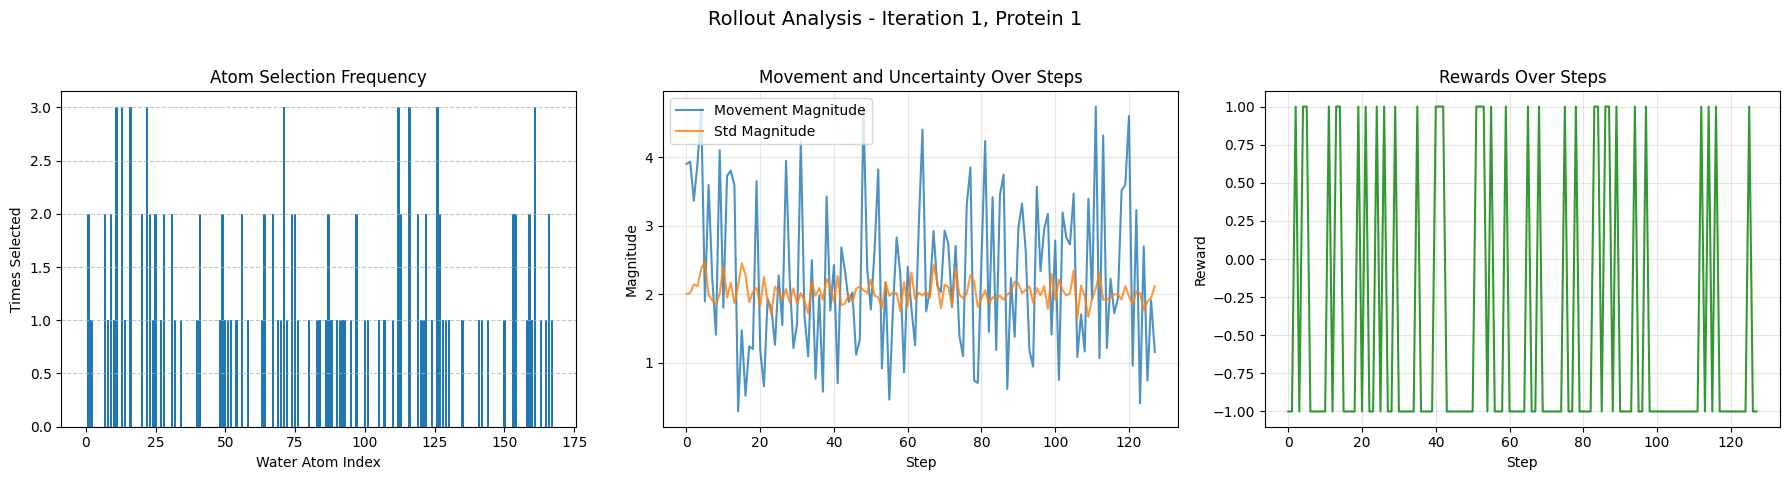

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.2586 | Value Loss: 51.7184 | Entropy: 4.1100
Policy Loss: 0.1555 | Value Loss: 44.0180 | Entropy: 4.2028
Policy Loss: 0.1032 | Value Loss: 36.4880 | Entropy: 4.2877
Policy Loss: 0.0877 | Value Loss: 31.0495 | Entropy: 4.3659
	Protein 2/10
	Saving initial noisy structure to 6APO_initial_noise.pdb
PDB saved to 6APO_initial_noise.pdb
CCP4 map saved to 6APO_initial_noise_target_density.ccp4


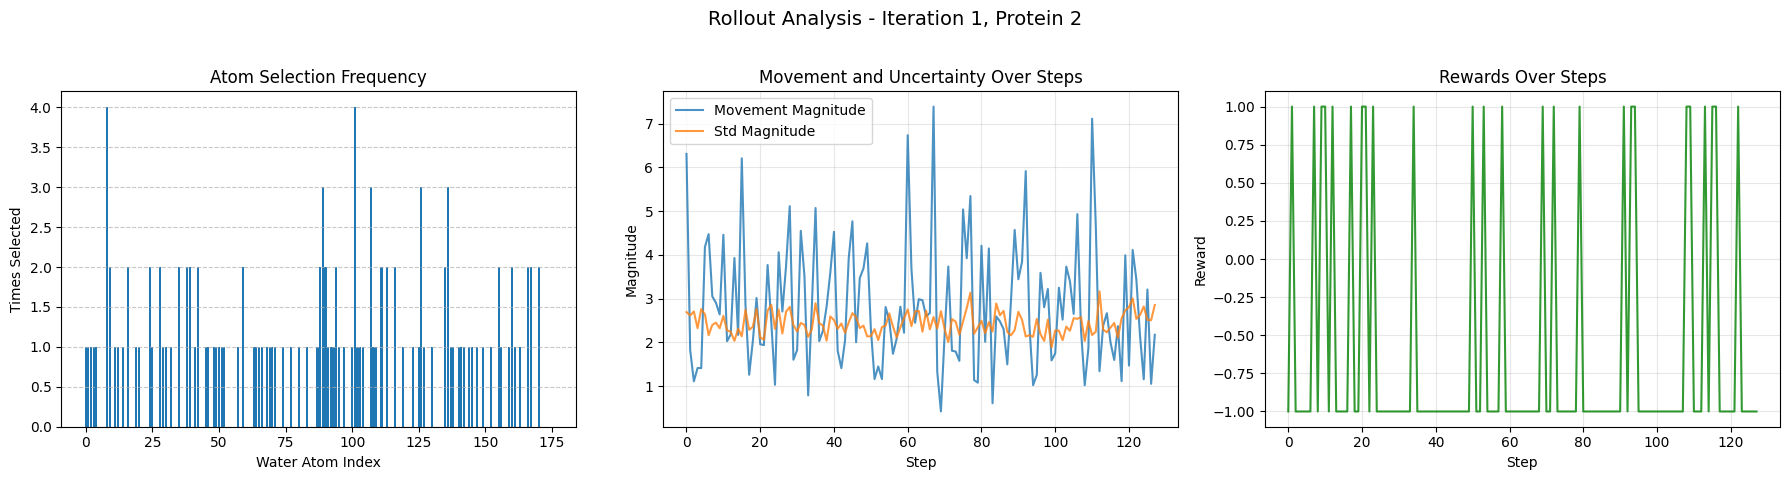

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0540 | Value Loss: 94.4627 | Entropy: 4.7327
Policy Loss: 0.0686 | Value Loss: 87.5809 | Entropy: 4.7247
Policy Loss: 0.1060 | Value Loss: 80.9018 | Entropy: 4.7893
Policy Loss: 0.0796 | Value Loss: 73.7474 | Entropy: 4.8479
	Protein 3/10
	Saving initial noisy structure to 4MQ3_initial_noise.pdb
PDB saved to 4MQ3_initial_noise.pdb
CCP4 map saved to 4MQ3_initial_noise_target_density.ccp4


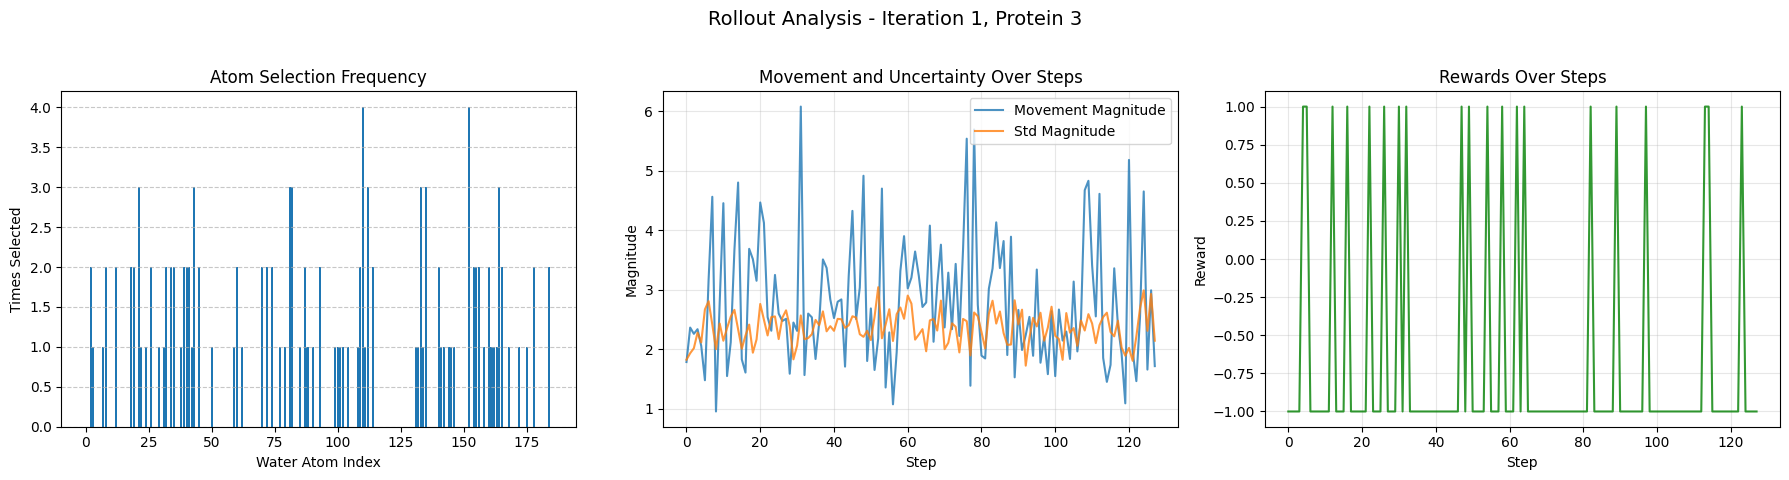

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.1260 | Value Loss: 112.1519 | Entropy: 4.4343
Policy Loss: 0.0473 | Value Loss: 107.4889 | Entropy: 4.4504
Policy Loss: 0.0734 | Value Loss: 100.5202 | Entropy: 4.5999
Policy Loss: 0.1073 | Value Loss: 92.6893 | Entropy: 4.6655
	Protein 4/10
	Saving initial noisy structure to 6L9O_initial_noise.pdb
PDB saved to 6L9O_initial_noise.pdb
CCP4 map saved to 6L9O_initial_noise_target_density.ccp4


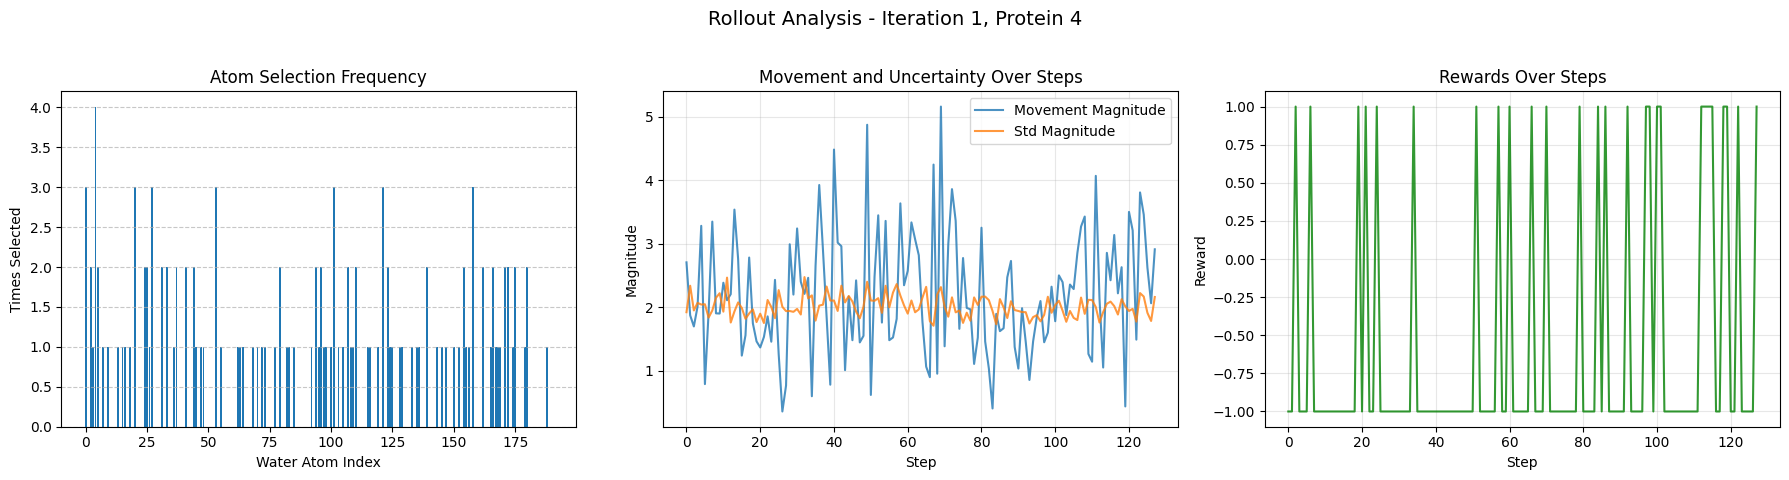

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.1848 | Value Loss: 84.8585 | Entropy: 4.5220
Policy Loss: 0.1342 | Value Loss: 80.5958 | Entropy: 4.5559
Policy Loss: 0.0942 | Value Loss: 75.3125 | Entropy: 4.5427
Policy Loss: 0.0844 | Value Loss: 68.9947 | Entropy: 4.5557
	Protein 5/10
	Saving initial noisy structure to 1ZLB_initial_noise.pdb
PDB saved to 1ZLB_initial_noise.pdb
CCP4 map saved to 1ZLB_initial_noise_target_density.ccp4


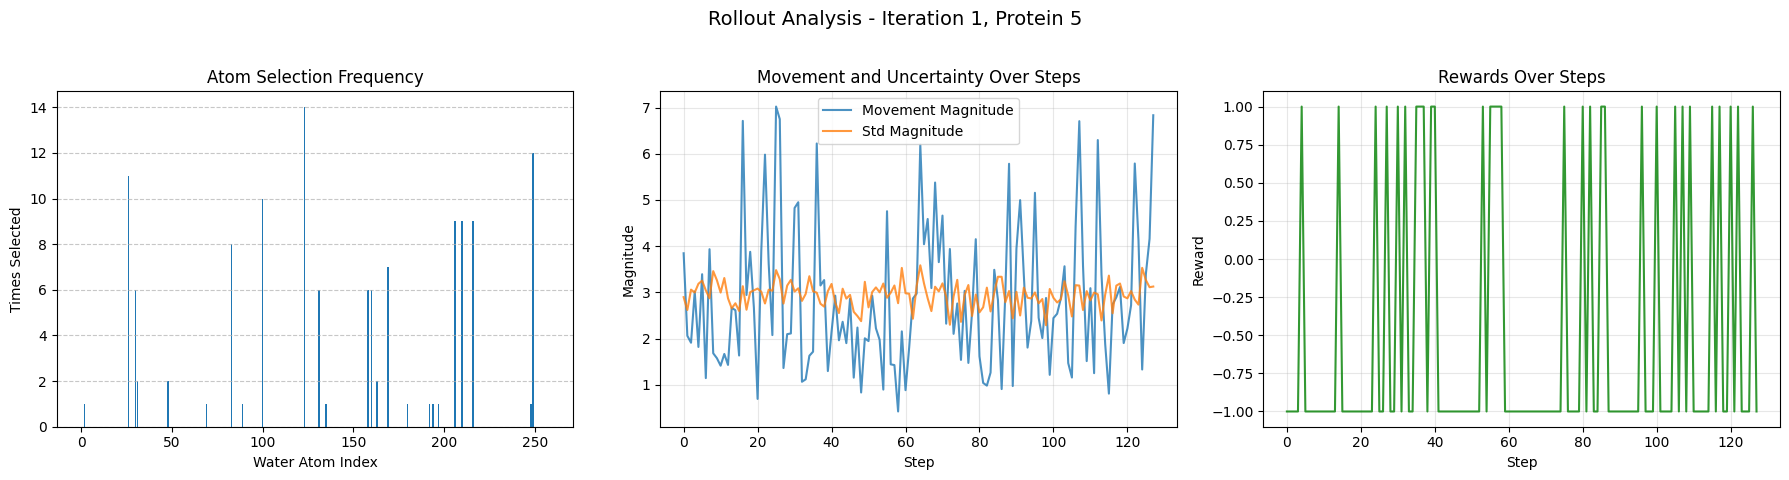

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.1407 | Value Loss: 55.6300 | Entropy: 4.8147
Policy Loss: 0.0970 | Value Loss: 51.2460 | Entropy: 4.7328
Policy Loss: 0.1183 | Value Loss: 47.2979 | Entropy: 4.7881
Policy Loss: 0.0368 | Value Loss: 41.4107 | Entropy: 4.8239
	Protein 6/10
	Saving initial noisy structure to 6YBE_initial_noise.pdb
PDB saved to 6YBE_initial_noise.pdb
CCP4 map saved to 6YBE_initial_noise_target_density.ccp4


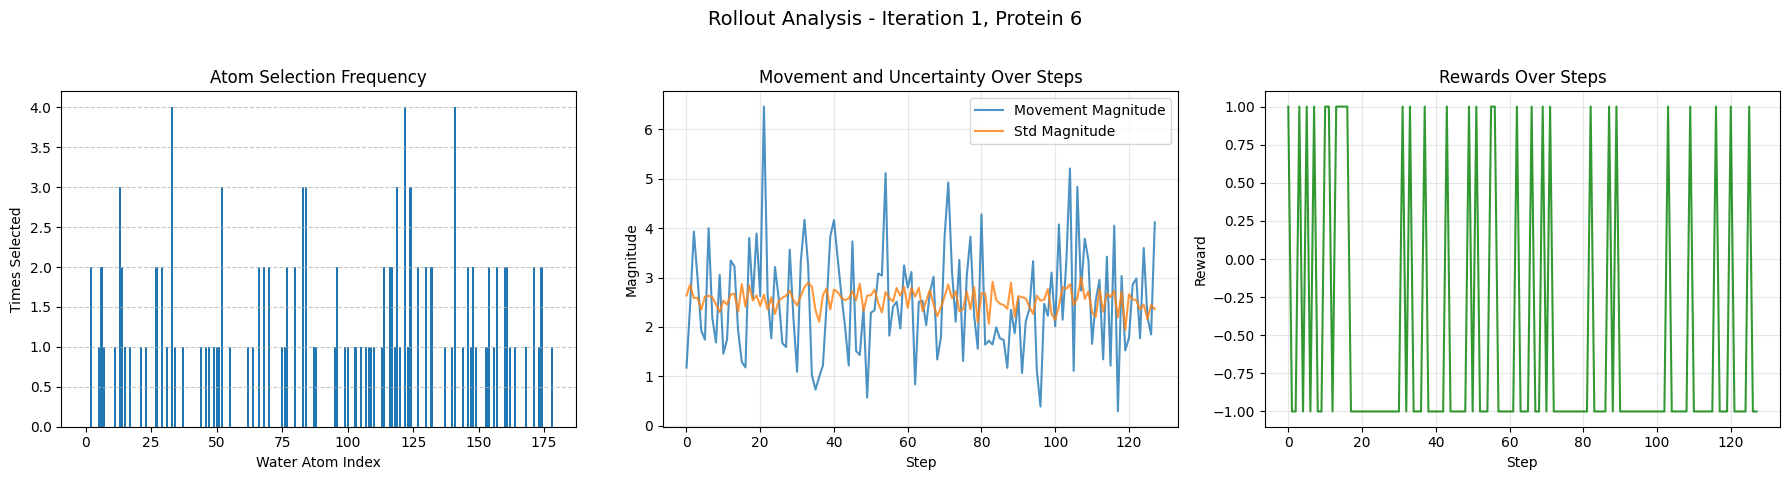

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0294 | Value Loss: 73.3048 | Entropy: 5.1587
Policy Loss: 0.0377 | Value Loss: 67.1082 | Entropy: 5.2019
Policy Loss: 0.0381 | Value Loss: 60.6745 | Entropy: 5.3104
Policy Loss: 0.0339 | Value Loss: 53.6922 | Entropy: 5.3320
	Protein 7/10
	Saving initial noisy structure to 6I42_initial_noise.pdb
PDB saved to 6I42_initial_noise.pdb
CCP4 map saved to 6I42_initial_noise_target_density.ccp4


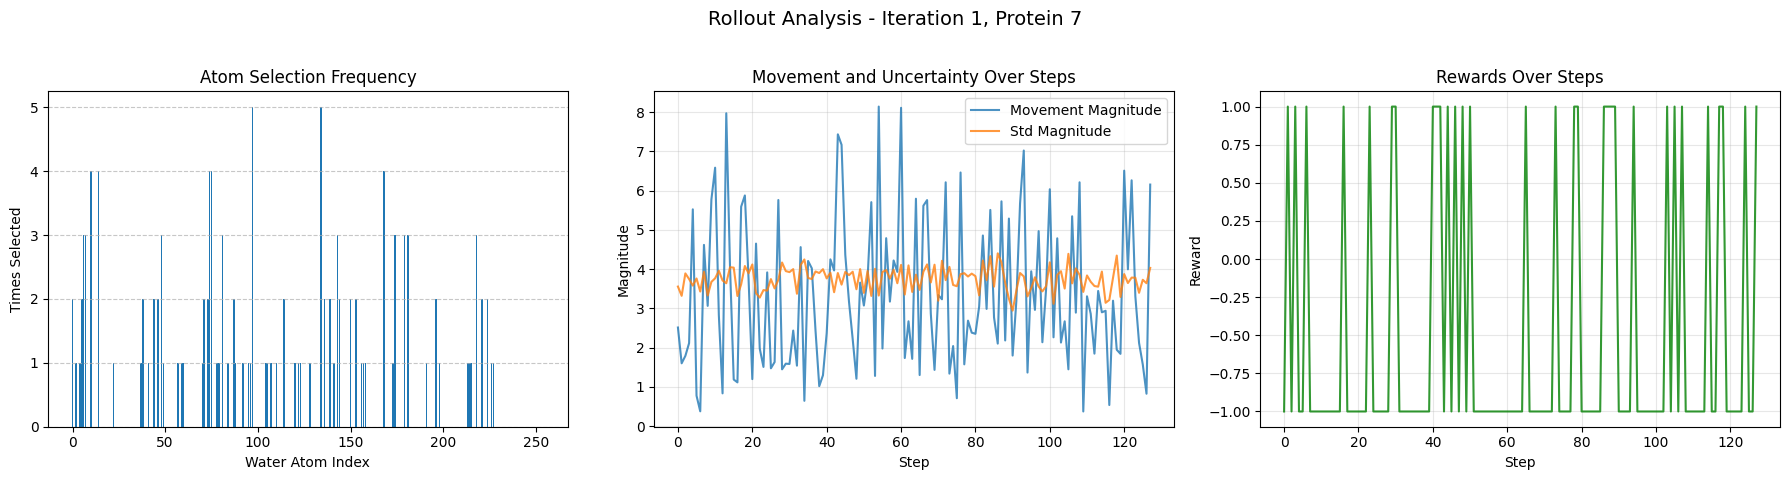

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.2014 | Value Loss: 52.9274 | Entropy: 5.0005
Policy Loss: 0.1220 | Value Loss: 46.4670 | Entropy: 5.1131
Policy Loss: 0.0763 | Value Loss: 39.8281 | Entropy: 5.2471
Policy Loss: 0.0806 | Value Loss: 33.2303 | Entropy: 5.4206
	Protein 8/10
	Saving initial noisy structure to 5E7B_initial_noise.pdb
PDB saved to 5E7B_initial_noise.pdb
CCP4 map saved to 5E7B_initial_noise_target_density.ccp4


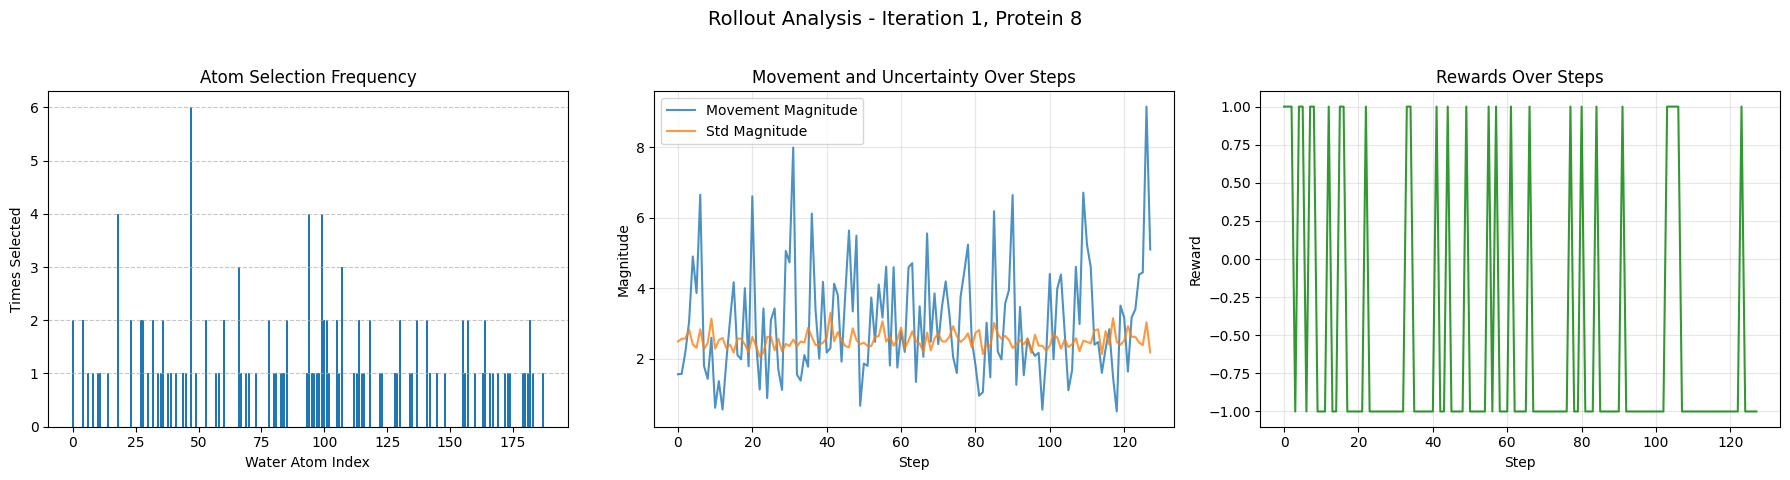

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0959 | Value Loss: 78.1196 | Entropy: 4.6724
Policy Loss: 0.0565 | Value Loss: 73.9977 | Entropy: 4.6965
Policy Loss: 0.0928 | Value Loss: 67.6919 | Entropy: 4.6962
Policy Loss: 0.0863 | Value Loss: 60.0190 | Entropy: 4.7374
	Protein 9/10
	Saving initial noisy structure to 7X70_initial_noise.pdb
PDB saved to 7X70_initial_noise.pdb
CCP4 map saved to 7X70_initial_noise_target_density.ccp4


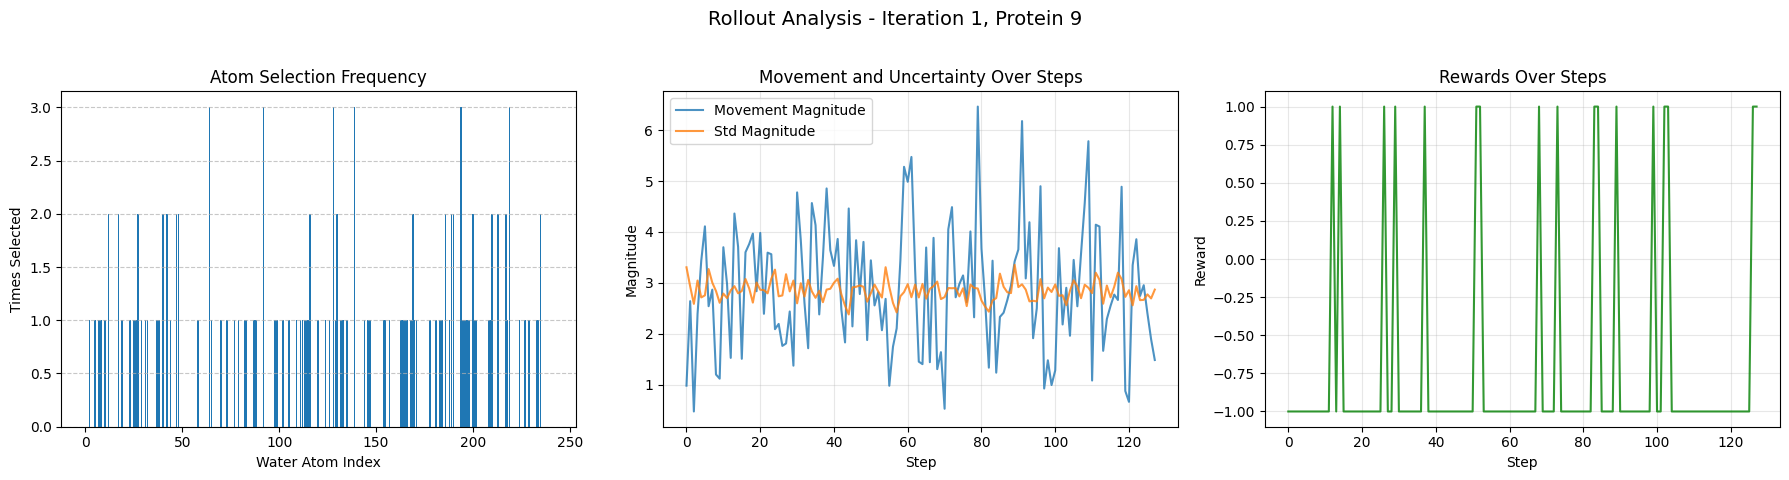

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0004 | Value Loss: 106.3509 | Entropy: 5.6568
Policy Loss: 0.0359 | Value Loss: 97.0069 | Entropy: 5.6507
Policy Loss: 0.0182 | Value Loss: 87.8518 | Entropy: 5.6291
Policy Loss: 0.0648 | Value Loss: 77.5005 | Entropy: 5.6273
	Protein 10/10
	Saving initial noisy structure to 6JGU_initial_noise.pdb
PDB saved to 6JGU_initial_noise.pdb
CCP4 map saved to 6JGU_initial_noise_target_density.ccp4


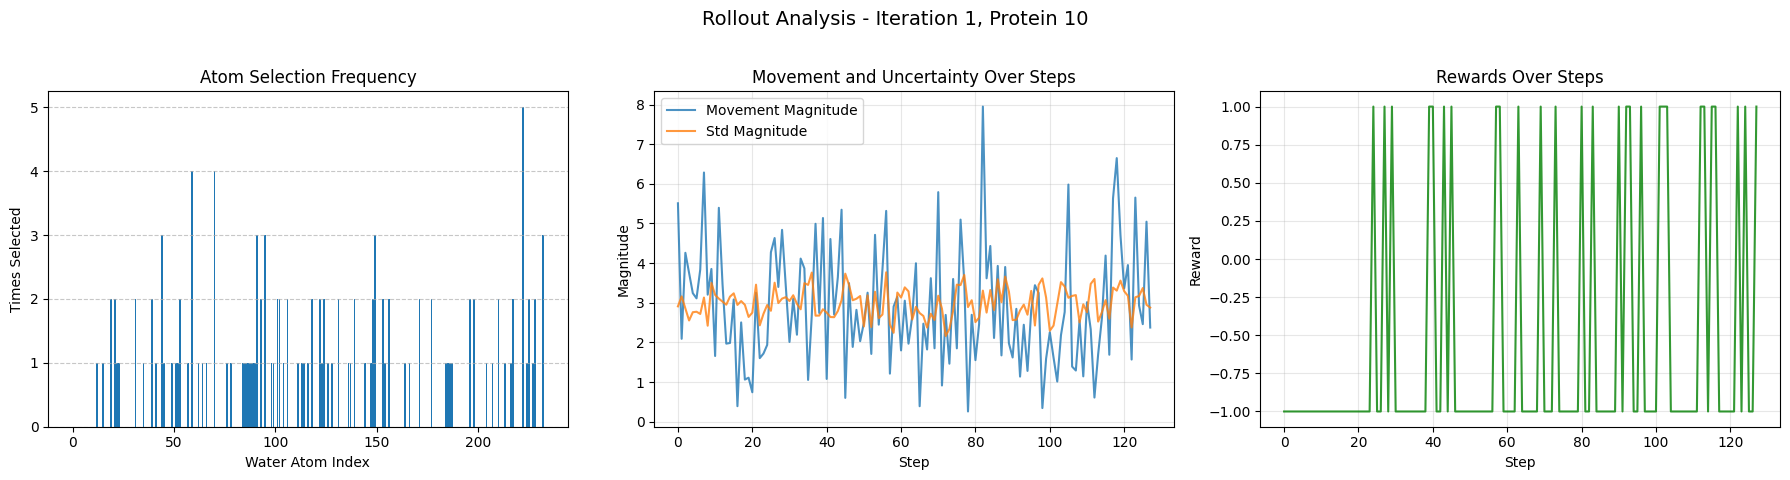

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.1220 | Value Loss: 53.8673 | Entropy: 5.4105
Policy Loss: 0.0608 | Value Loss: 48.4765 | Entropy: 5.3891
Policy Loss: 0.0793 | Value Loss: 43.1620 | Entropy: 5.3564
Policy Loss: 0.0437 | Value Loss: 36.0724 | Entropy: 5.3062

==================== EVALUATING ON TEST SET ====================

--- Starting Test Protein 1/10 --- 
  Starting  Distance=2.2732, Coverage=0.0000, Precision=0.0000
  Finished in 2500 steps. Final Distance=268.2603, Coverage=0.0000, Precision=0.0000


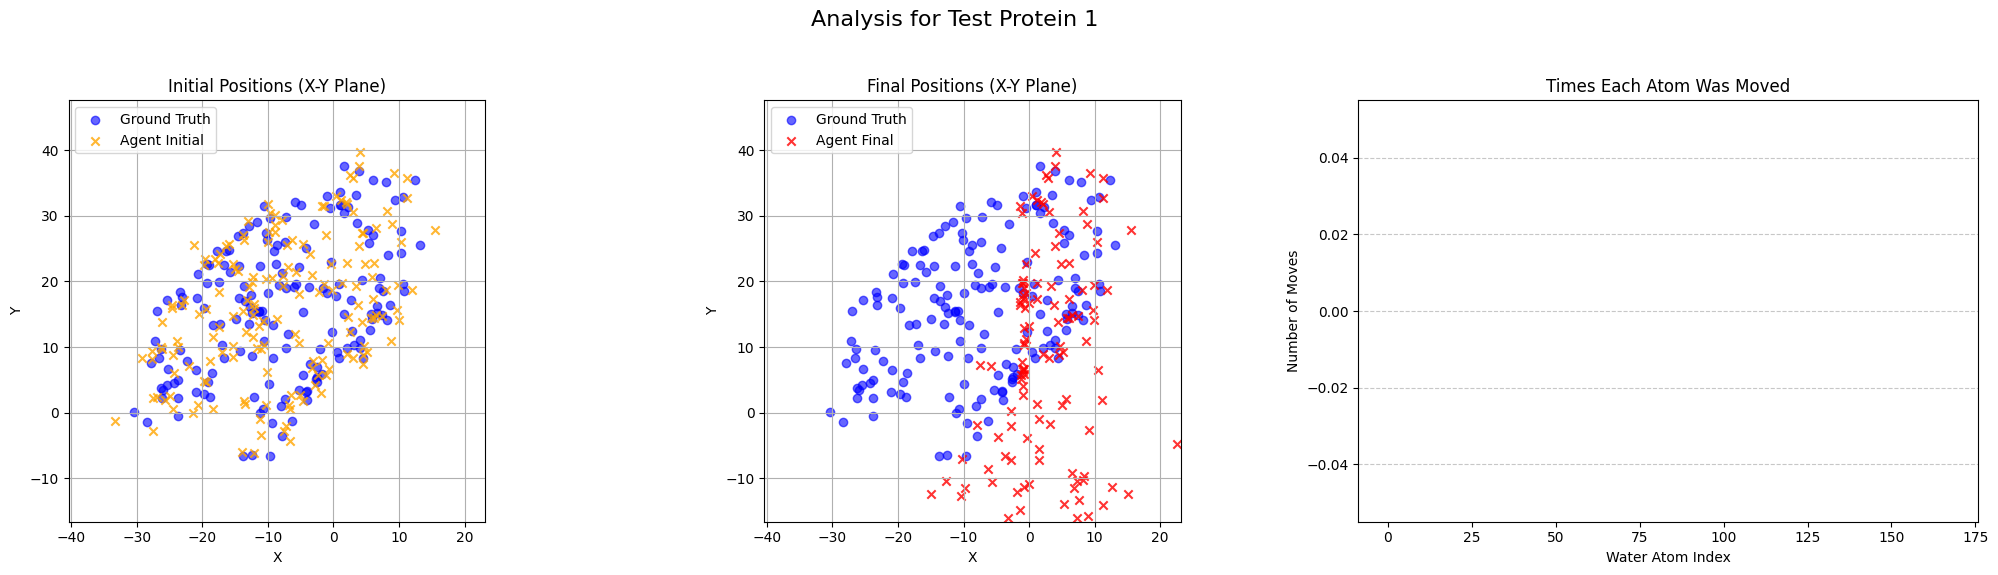


--- Starting Test Protein 2/10 --- 
  Starting  Distance=2.2839, Coverage=0.0114, Precision=0.0114
  Finished in 2500 steps. Final Distance=337.4954, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 3/10 --- 
  Starting  Distance=2.1468, Coverage=0.0108, Precision=0.0108
  Finished in 2500 steps. Final Distance=185.1047, Coverage=0.0054, Precision=0.0054

--- Starting Test Protein 4/10 --- 
  Starting  Distance=2.1473, Coverage=0.0052, Precision=0.0052
  Finished in 2500 steps. Final Distance=170.8203, Coverage=0.0052, Precision=0.0052

--- Starting Test Protein 5/10 --- 
  Starting  Distance=2.2159, Coverage=0.0039, Precision=0.0039
  Finished in 2500 steps. Final Distance=370.7522, Coverage=0.0039, Precision=0.0039

--- Starting Test Protein 6/10 --- 
  Starting  Distance=2.2500, Coverage=0.0112, Precision=0.0112
  Finished in 2500 steps. Final Distance=125.8500, Coverage=0.0056, Precision=0.0056


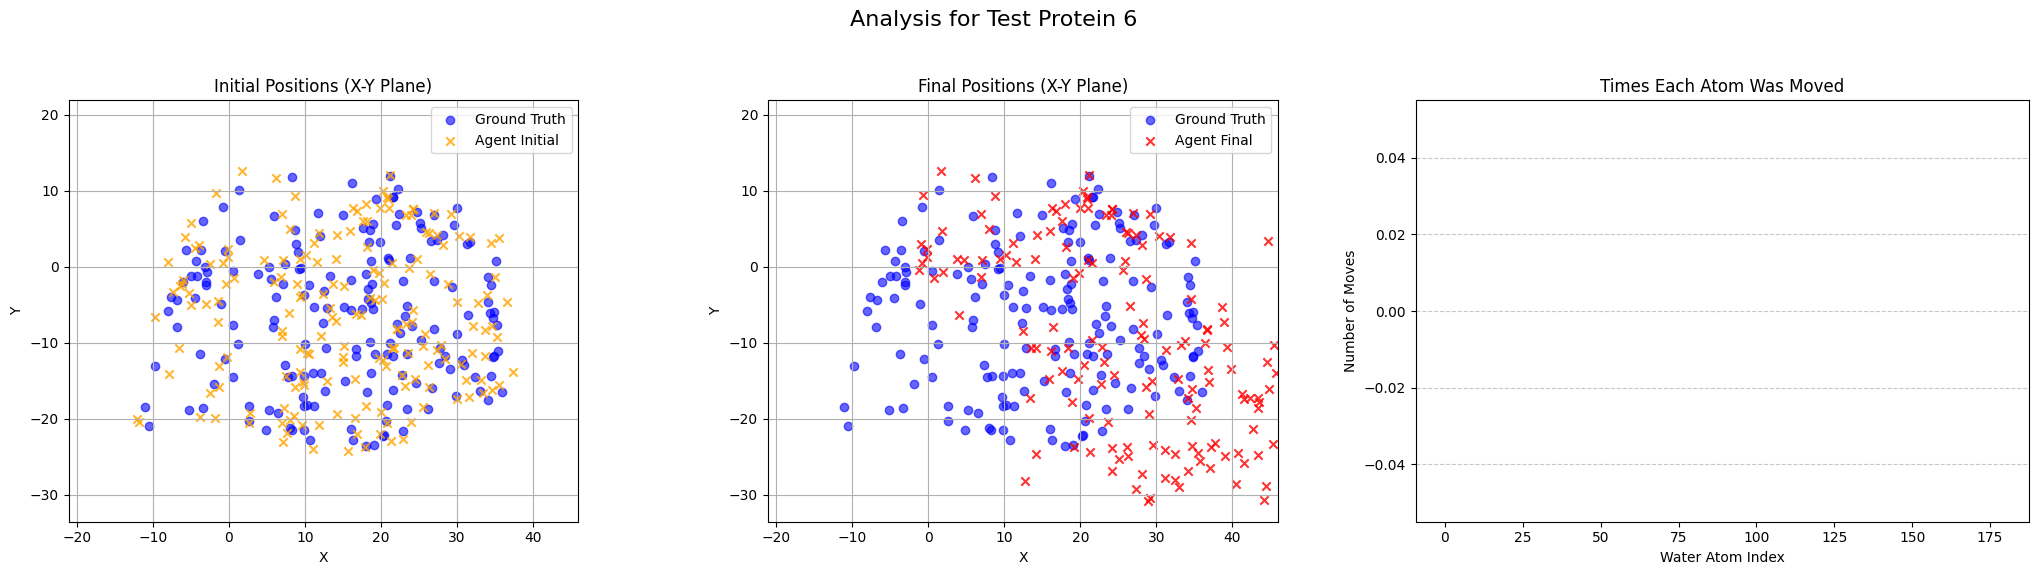


--- Starting Test Protein 7/10 --- 
  Starting  Distance=2.2646, Coverage=0.0078, Precision=0.0078
  Finished in 2500 steps. Final Distance=186.5921, Coverage=0.0078, Precision=0.0078

--- Starting Test Protein 8/10 --- 
  Starting  Distance=2.2368, Coverage=0.0053, Precision=0.0053
  Finished in 2500 steps. Final Distance=297.4498, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 9/10 --- 
  Starting  Distance=2.3606, Coverage=0.0124, Precision=0.0124
  Finished in 2500 steps. Final Distance=59.9558, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 10/10 --- 
  Starting  Distance=2.1521, Coverage=0.0043, Precision=0.0043
  Finished in 2500 steps. Final Distance=45.3601, Coverage=0.0000, Precision=0.0000

-------------------- TEST SUMMARY --------------------
Average Final Distance (MSE) on Test Set: 204.7641
Average Final Correlation on Test Set:  nan
Average Coverage on Test Set:         0.0028
Average Precision on Test Set:        0.0028


=== Iteration 2/5 

/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


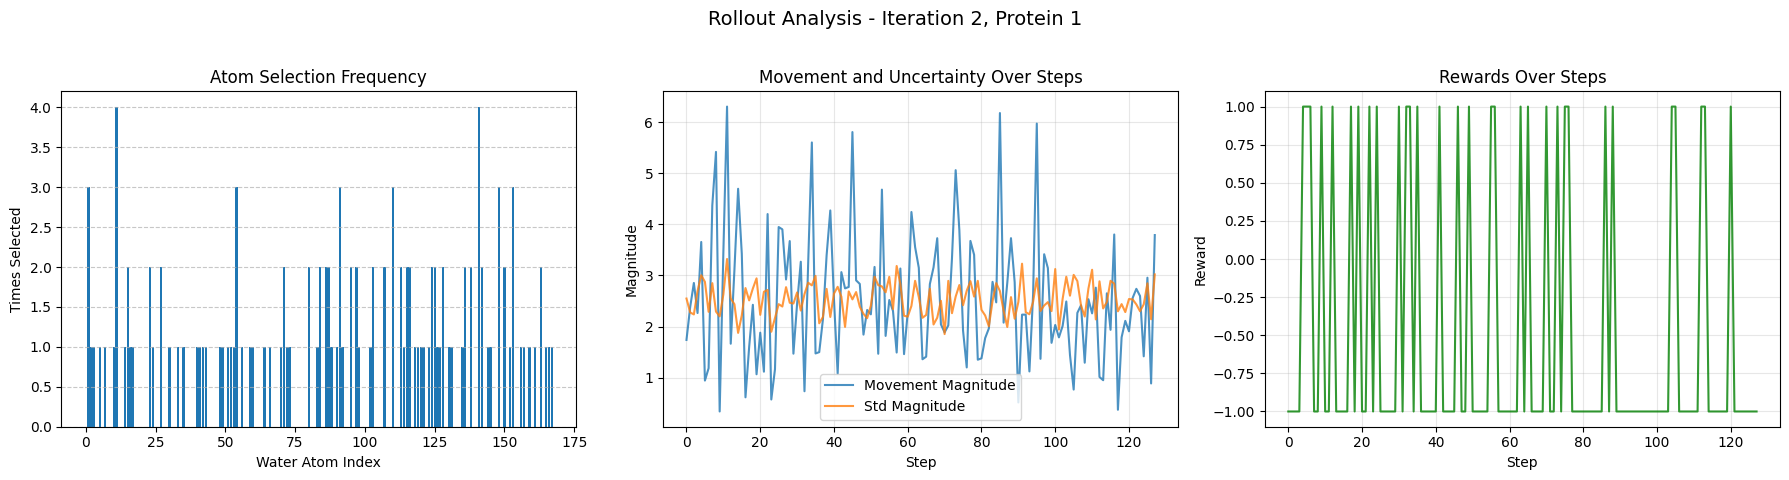

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0455 | Value Loss: 51.0058 | Entropy: 4.7460
Policy Loss: 0.0689 | Value Loss: 44.9031 | Entropy: 4.7806
Policy Loss: 0.0325 | Value Loss: 37.1187 | Entropy: 4.7990
Policy Loss: 0.0502 | Value Loss: 29.1141 | Entropy: 4.8219
	Protein 2/10


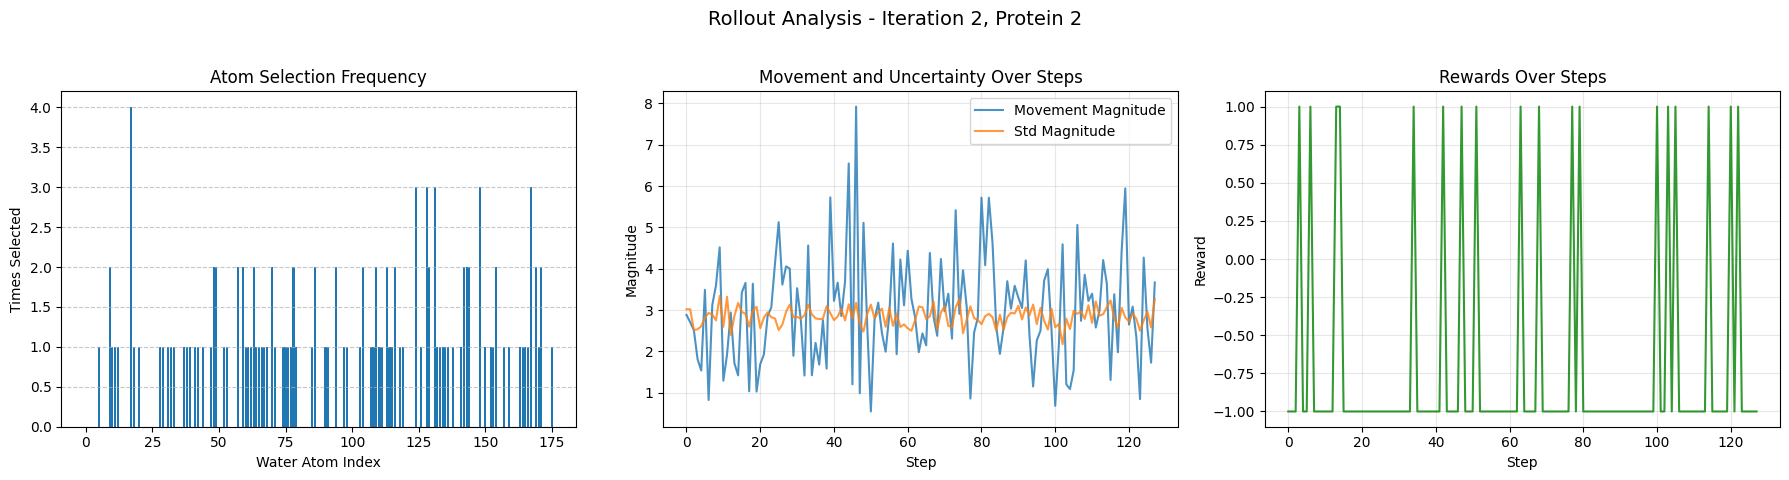

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0784 | Value Loss: 96.9188 | Entropy: 5.0998
Policy Loss: 0.0719 | Value Loss: 87.3626 | Entropy: 5.0399
Policy Loss: 0.0770 | Value Loss: 76.2784 | Entropy: 5.0579
Policy Loss: 0.0578 | Value Loss: 66.0311 | Entropy: 5.0082
	Protein 3/10


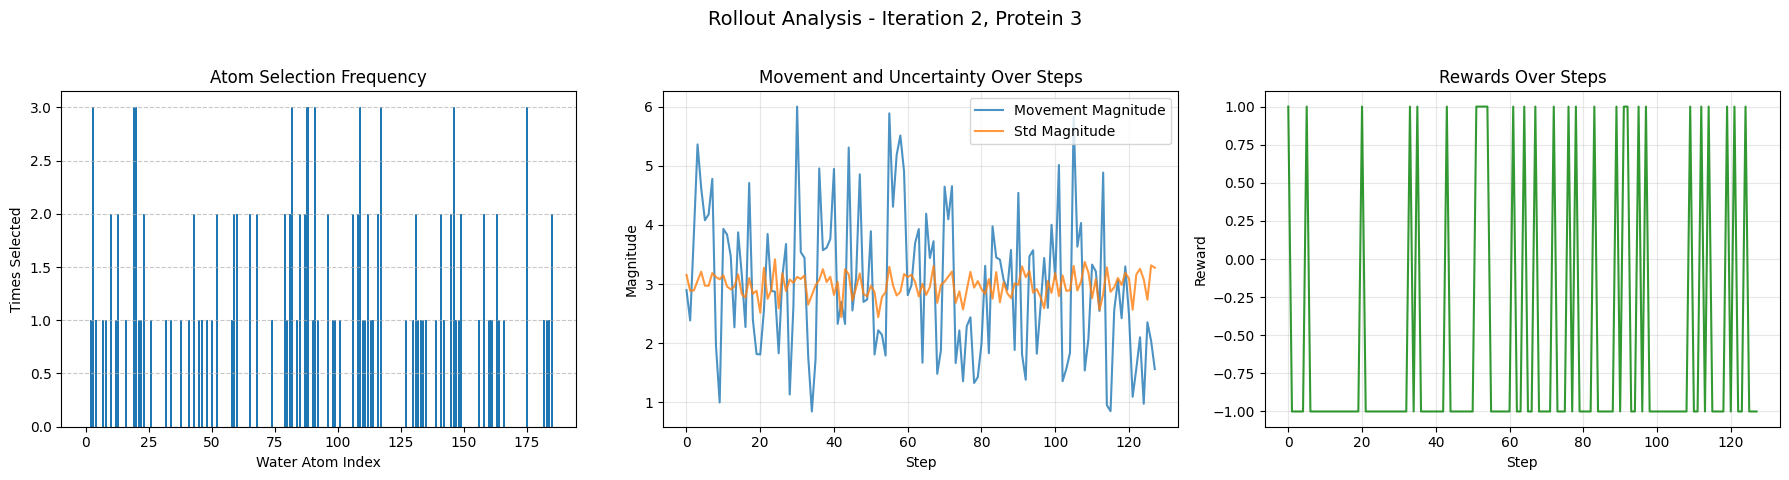

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0400 | Value Loss: 41.9769 | Entropy: 5.4998
Policy Loss: 0.0239 | Value Loss: 36.8136 | Entropy: 5.5101
Policy Loss: -0.0134 | Value Loss: 31.4916 | Entropy: 5.5506
Policy Loss: 0.0220 | Value Loss: 25.7436 | Entropy: 5.5566
	Protein 4/10


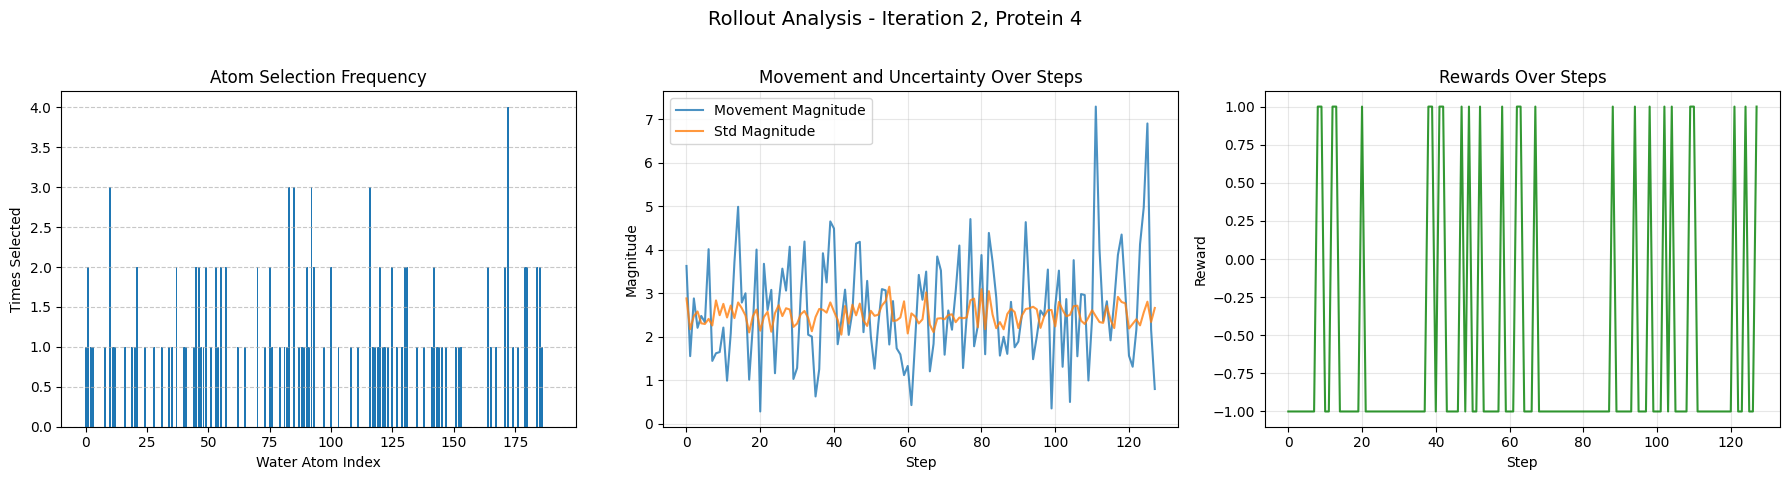

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0371 | Value Loss: 67.5606 | Entropy: 4.7305
Policy Loss: 0.0615 | Value Loss: 60.1209 | Entropy: 4.7760
Policy Loss: 0.0225 | Value Loss: 51.5926 | Entropy: 4.8203
Policy Loss: 0.0818 | Value Loss: 40.9721 | Entropy: 4.9267
	Protein 5/10


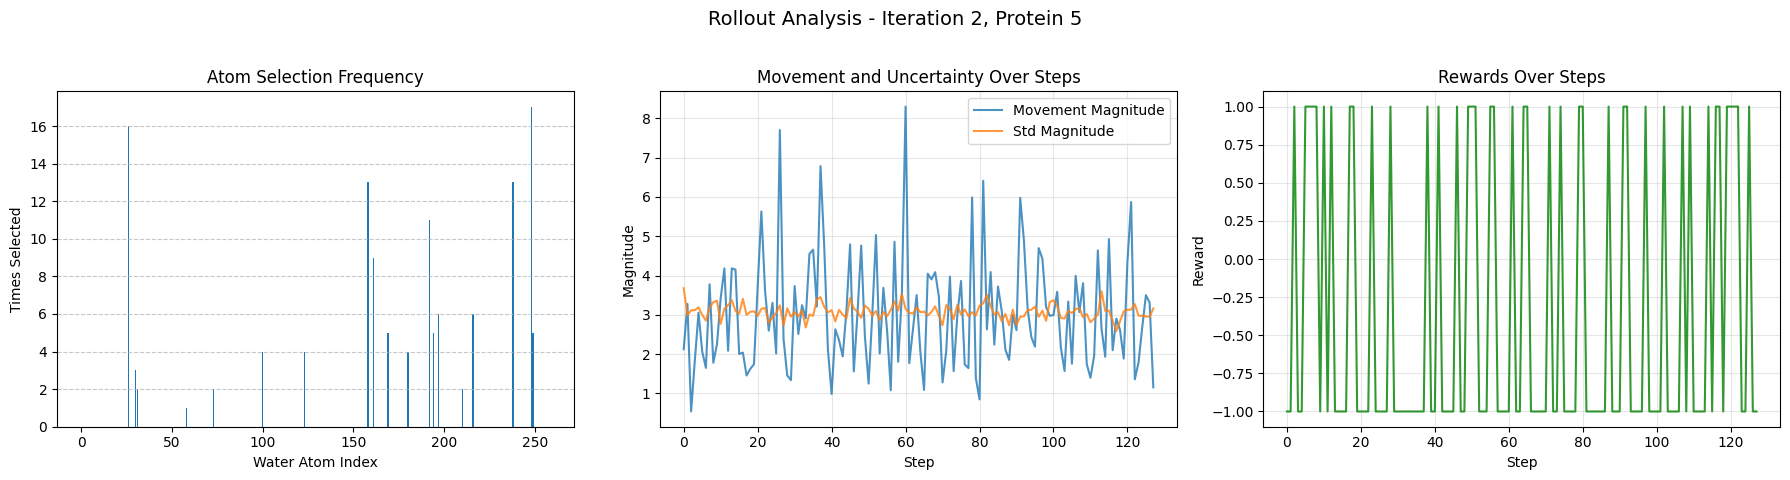

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0119 | Value Loss: 13.0726 | Entropy: 5.7615
Policy Loss: 0.0191 | Value Loss: 10.2123 | Entropy: 5.7873
Policy Loss: -0.0096 | Value Loss: 7.9510 | Entropy: 5.8301
Policy Loss: -0.0141 | Value Loss: 7.4520 | Entropy: 5.9004
	Protein 6/10


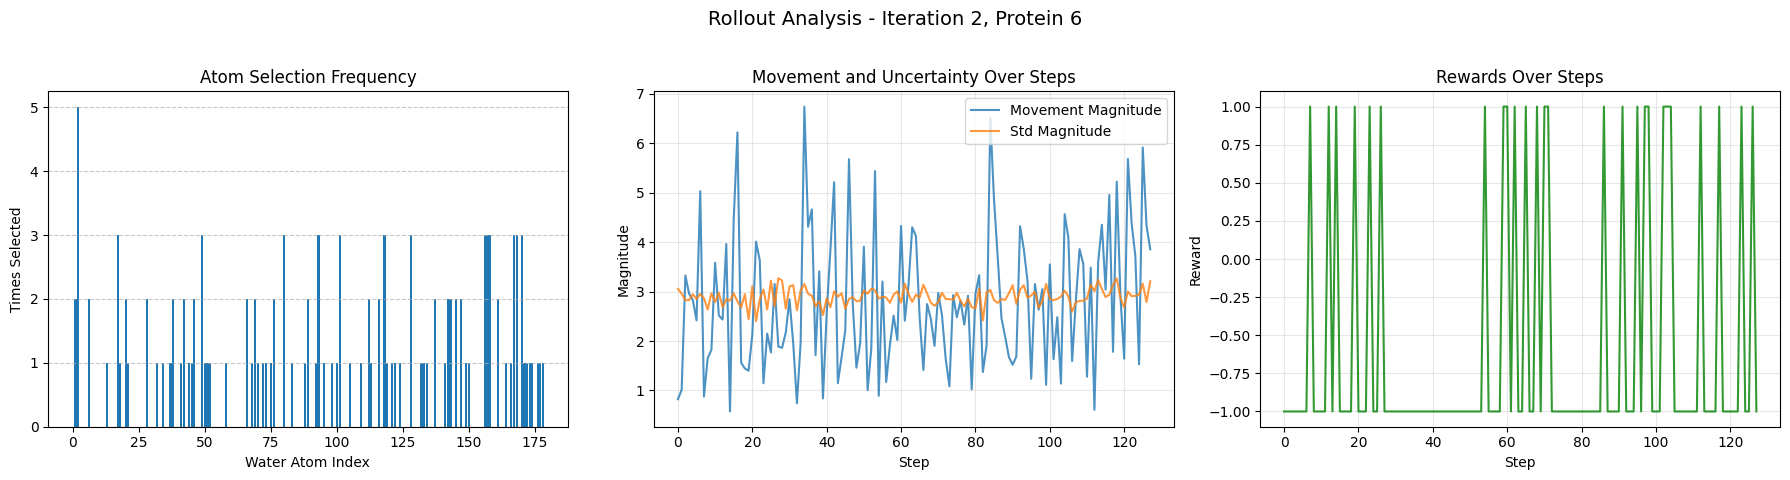

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0464 | Value Loss: 41.1445 | Entropy: 5.7177
Policy Loss: 0.0739 | Value Loss: 33.4690 | Entropy: 5.7819
Policy Loss: 0.0443 | Value Loss: 25.9350 | Entropy: 5.8323
Policy Loss: 0.0367 | Value Loss: 19.0165 | Entropy: 5.9112
	Protein 7/10


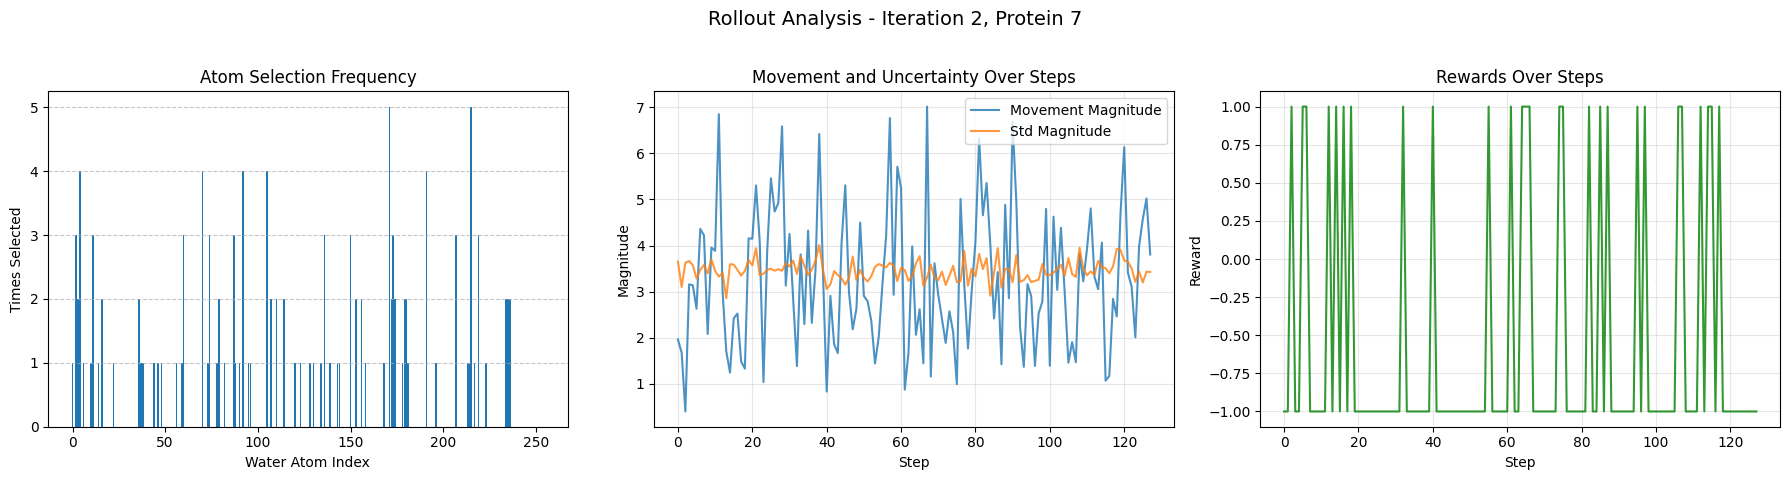

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0694 | Value Loss: 26.5903 | Entropy: 6.0395
Policy Loss: 0.1955 | Value Loss: 16.9178 | Entropy: 6.0602
Policy Loss: 0.0972 | Value Loss: 9.6291 | Entropy: 6.0496
Policy Loss: 0.0614 | Value Loss: 5.8086 | Entropy: 6.0148
	Protein 8/10


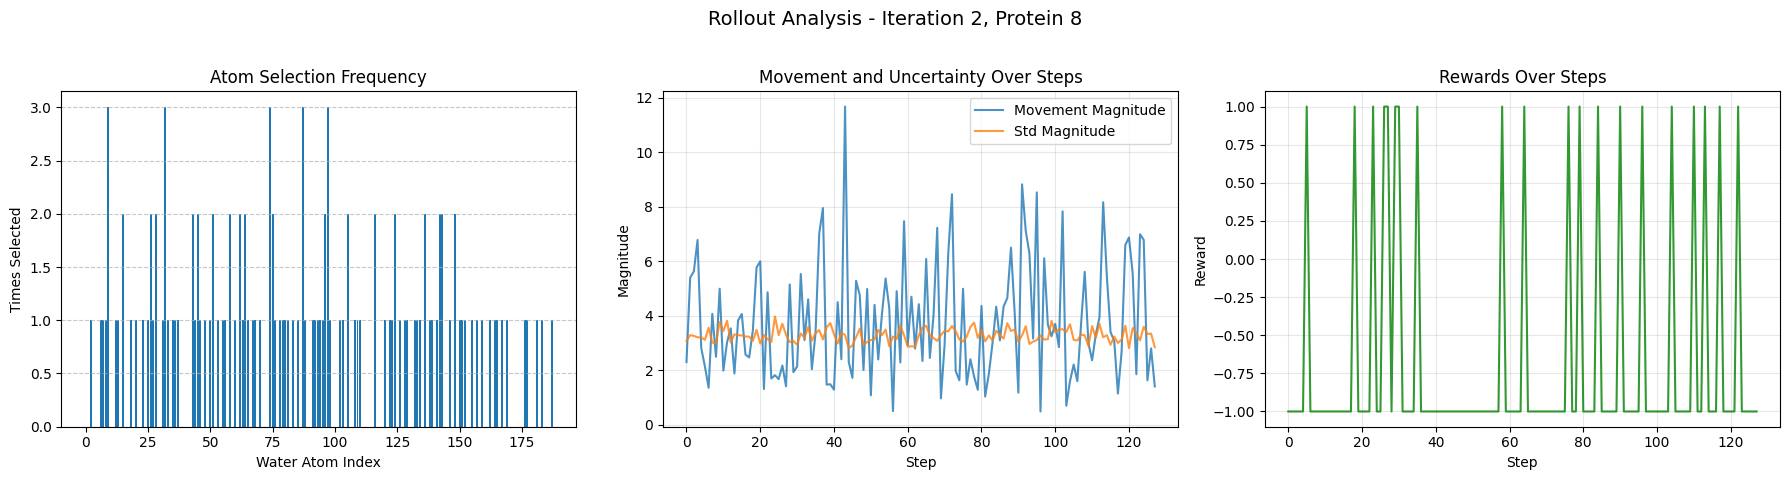

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0368 | Value Loss: 60.6815 | Entropy: 5.5282
Policy Loss: 0.0203 | Value Loss: 51.6710 | Entropy: 5.5258
Policy Loss: 0.0592 | Value Loss: 39.1425 | Entropy: 5.5495
Policy Loss: 0.0418 | Value Loss: 26.3047 | Entropy: 5.5502
	Protein 9/10


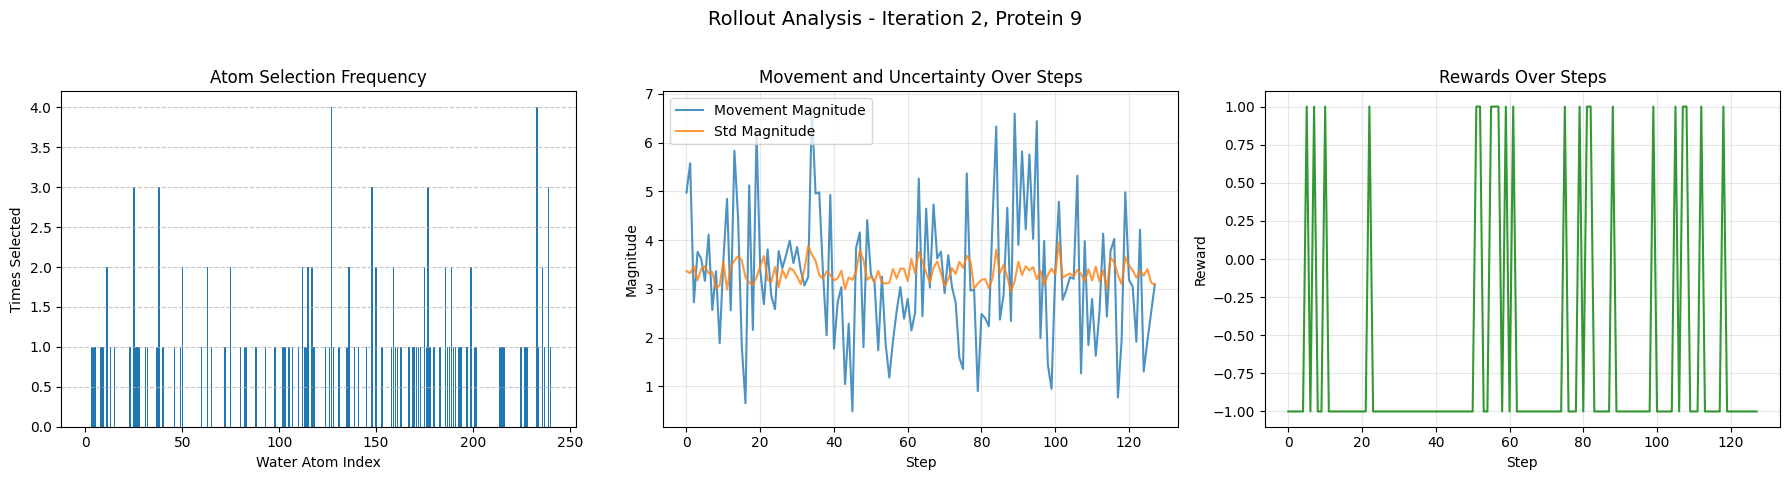

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0694 | Value Loss: 37.9570 | Entropy: 6.0623
Policy Loss: 0.0363 | Value Loss: 27.2493 | Entropy: 6.0670
Policy Loss: 0.0295 | Value Loss: 18.1100 | Entropy: 6.0257
Policy Loss: 0.0343 | Value Loss: 13.6099 | Entropy: 6.0097
	Protein 10/10


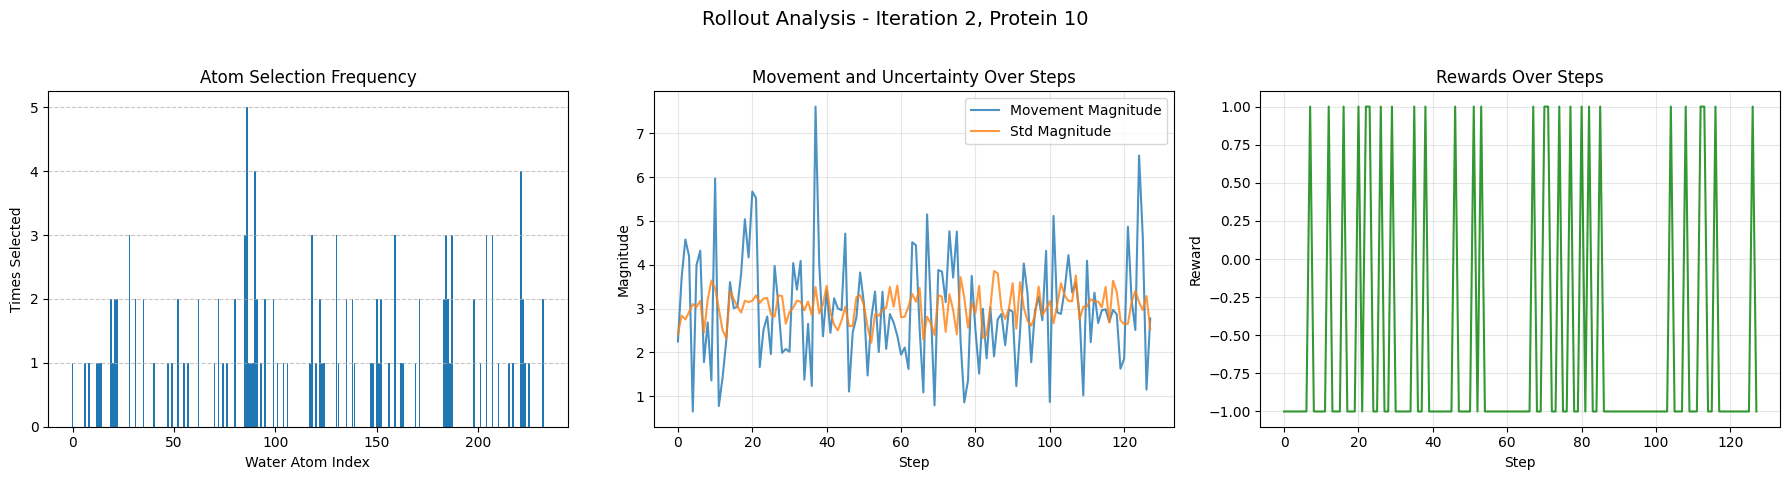

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0100 | Value Loss: 18.8511 | Entropy: 5.4563
Policy Loss: 0.0228 | Value Loss: 13.4588 | Entropy: 5.4685
Policy Loss: 0.0089 | Value Loss: 8.1988 | Entropy: 5.5198
Policy Loss: -0.0047 | Value Loss: 7.2741 | Entropy: 5.5819

==================== EVALUATING ON TEST SET ====================

--- Starting Test Protein 1/10 --- 
  Starting  Distance=2.2525, Coverage=0.0060, Precision=0.0060
  Finished in 2500 steps. Final Distance=107.3908, Coverage=0.0060, Precision=0.0060


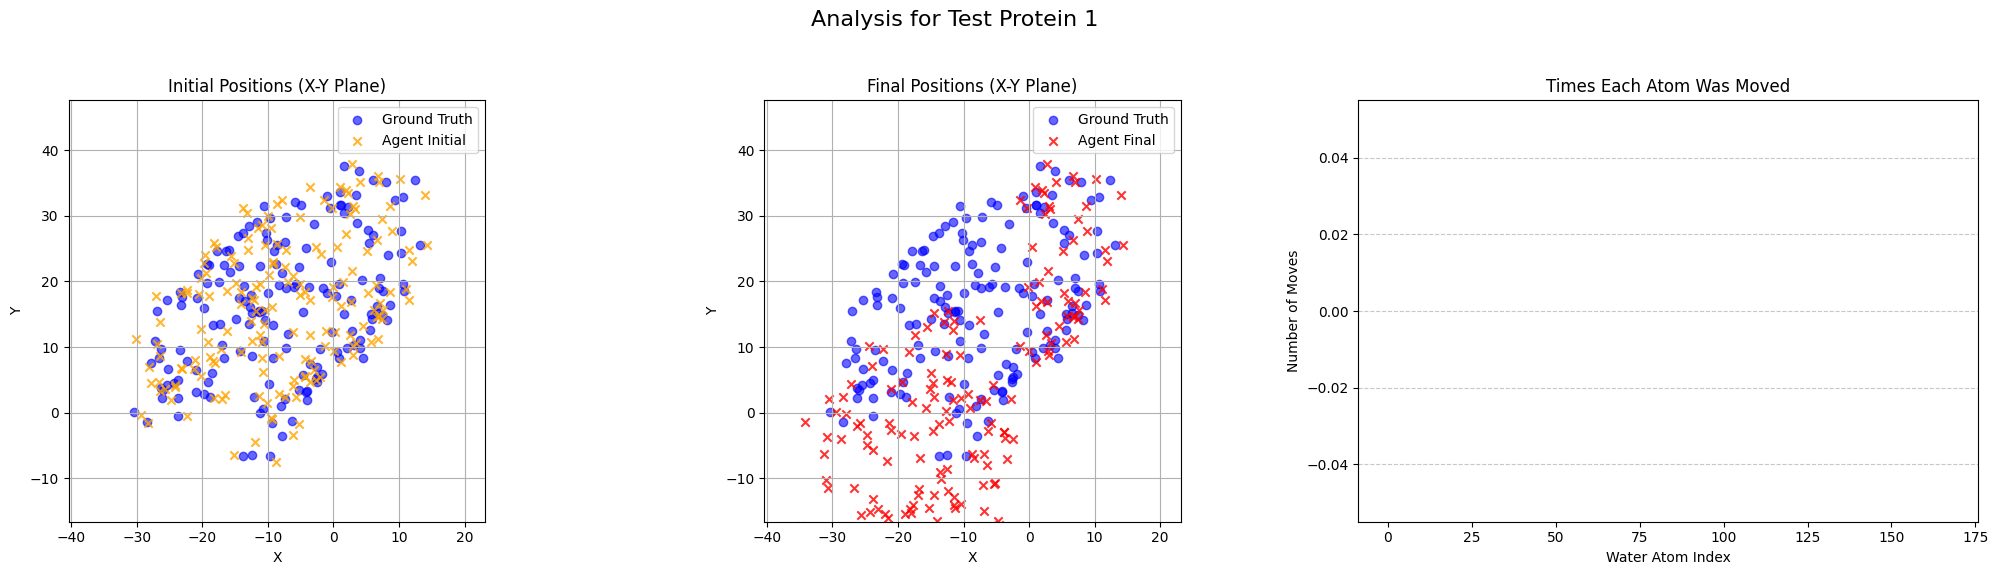


--- Starting Test Protein 2/10 --- 
  Starting  Distance=2.3836, Coverage=0.0057, Precision=0.0057
  Finished in 2500 steps. Final Distance=136.6659, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 3/10 --- 
  Starting  Distance=2.3935, Coverage=0.0108, Precision=0.0108
  Finished in 2500 steps. Final Distance=211.6469, Coverage=0.0108, Precision=0.0108

--- Starting Test Protein 4/10 --- 
  Starting  Distance=2.3358, Coverage=0.0052, Precision=0.0052
  Finished in 2500 steps. Final Distance=160.2264, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 5/10 --- 
  Starting  Distance=2.3625, Coverage=0.0116, Precision=0.0116
  Finished in 2500 steps. Final Distance=1710.6654, Coverage=0.0116, Precision=0.0116

--- Starting Test Protein 6/10 --- 
  Starting  Distance=2.5837, Coverage=0.0000, Precision=0.0000
  Finished in 2500 steps. Final Distance=106.2636, Coverage=0.0000, Precision=0.0000


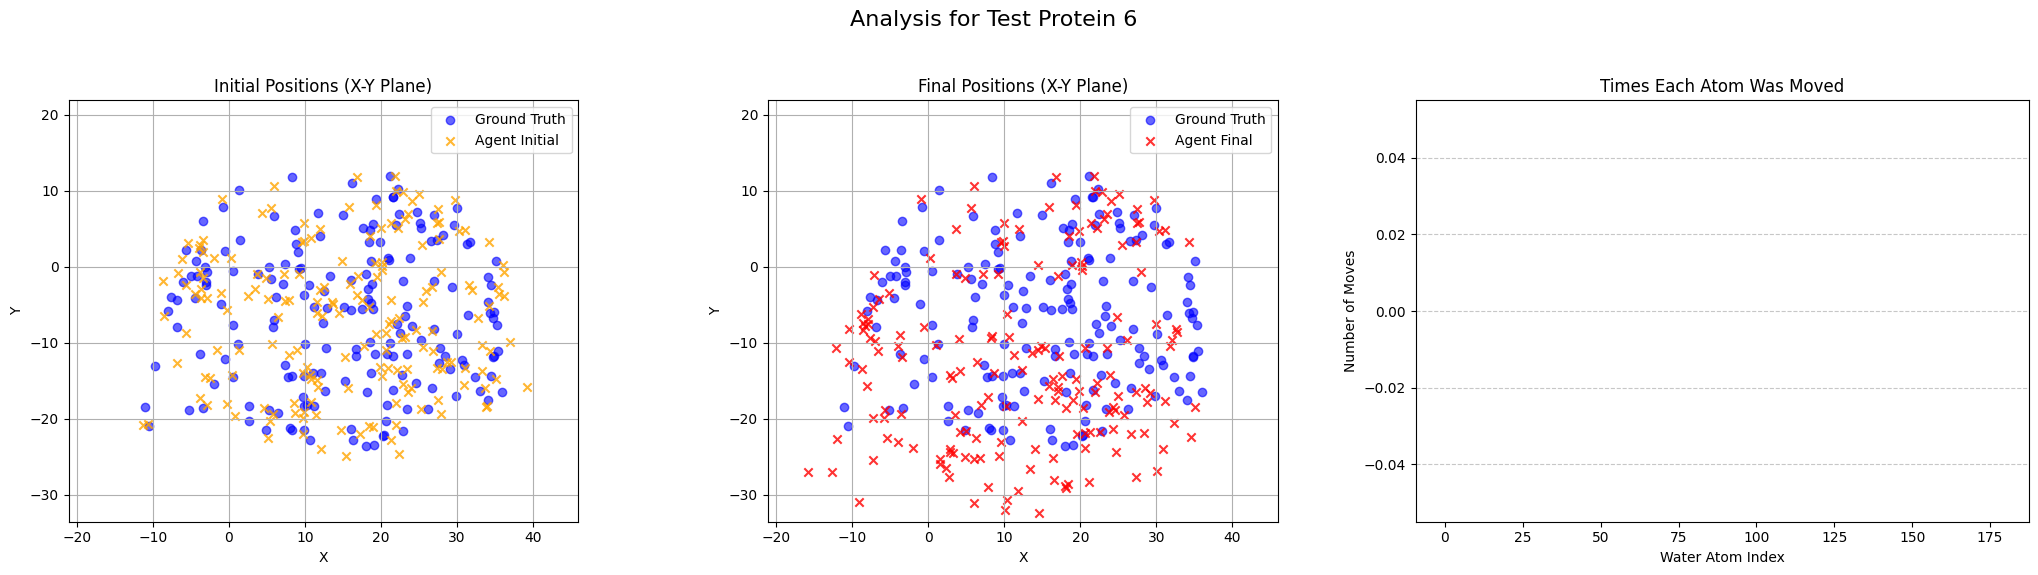


--- Starting Test Protein 7/10 --- 
  Starting  Distance=2.1092, Coverage=0.0275, Precision=0.0275
  Finished in 2500 steps. Final Distance=259.4844, Coverage=0.0118, Precision=0.0118

--- Starting Test Protein 8/10 --- 
  Starting  Distance=2.4108, Coverage=0.0160, Precision=0.0160
  Finished in 2500 steps. Final Distance=191.8674, Coverage=0.0053, Precision=0.0053

--- Starting Test Protein 9/10 --- 
  Starting  Distance=2.1462, Coverage=0.0083, Precision=0.0083
  Finished in 2500 steps. Final Distance=55.2514, Coverage=0.0083, Precision=0.0083

--- Starting Test Protein 10/10 --- 
  Starting  Distance=2.2414, Coverage=0.0172, Precision=0.0172
  Finished in 2500 steps. Final Distance=203.8419, Coverage=0.0172, Precision=0.0172

-------------------- TEST SUMMARY --------------------
Average Final Distance (MSE) on Test Set: 314.3304
Average Final Correlation on Test Set:  nan
Average Coverage on Test Set:         0.0071
Average Precision on Test Set:        0.0071


=== Iteration 3/5

/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


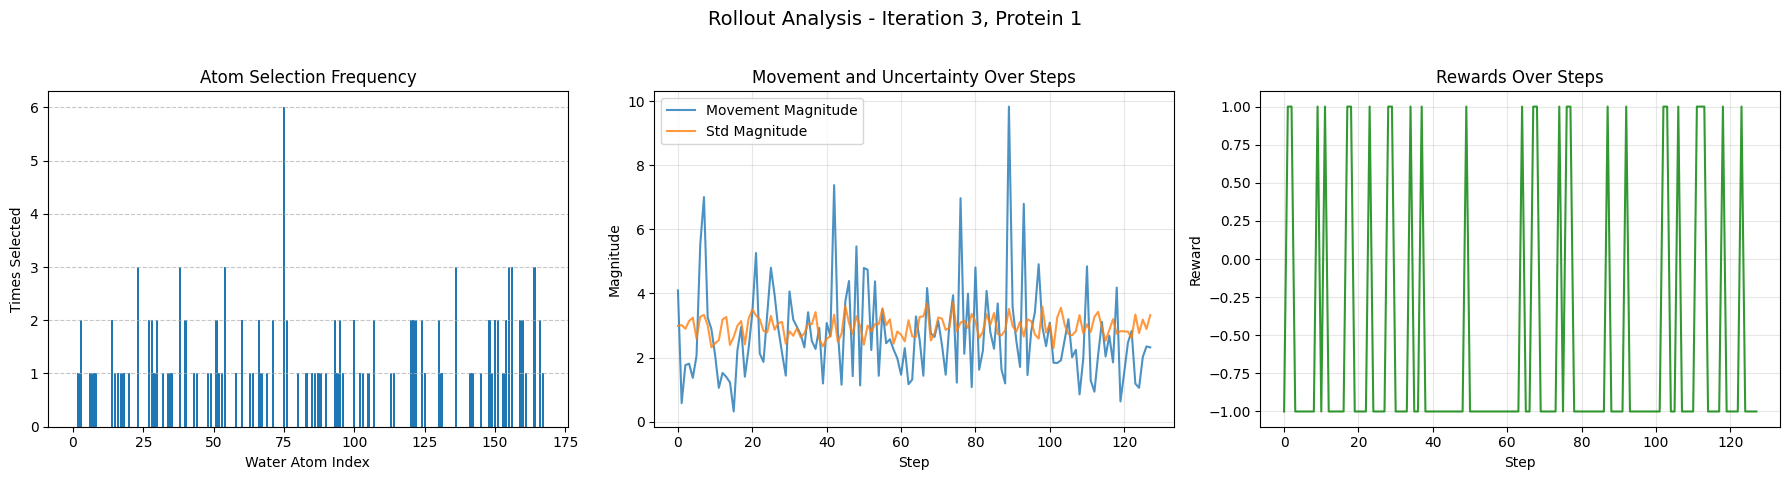

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.1117 | Value Loss: 24.3483 | Entropy: 4.8693
Policy Loss: 0.1540 | Value Loss: 18.6455 | Entropy: 4.9135
Policy Loss: 0.1173 | Value Loss: 13.0647 | Entropy: 4.8402
Policy Loss: 0.1385 | Value Loss: 9.3853 | Entropy: 4.8285
	Protein 2/10


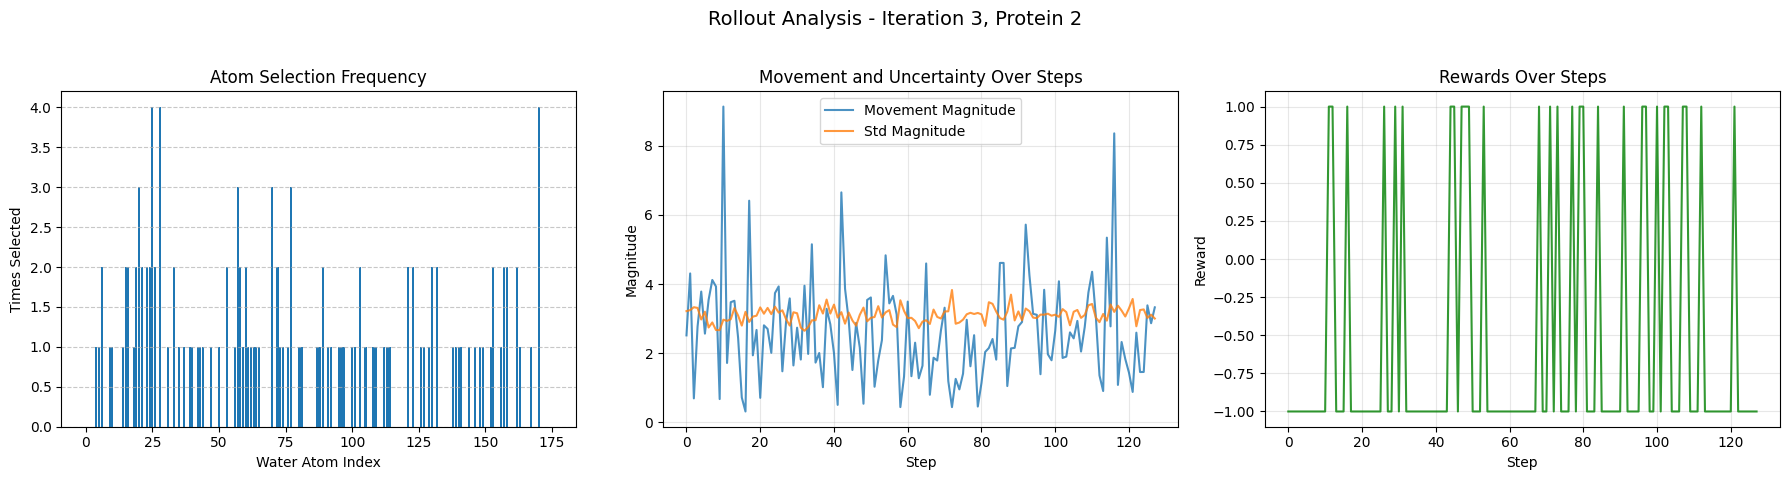

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0550 | Value Loss: 16.1383 | Entropy: 4.9406
Policy Loss: 0.0672 | Value Loss: 9.7617 | Entropy: 4.9380
Policy Loss: 0.0570 | Value Loss: 6.1087 | Entropy: 5.0004
Policy Loss: 0.0621 | Value Loss: 6.2348 | Entropy: 5.0678
	Protein 3/10


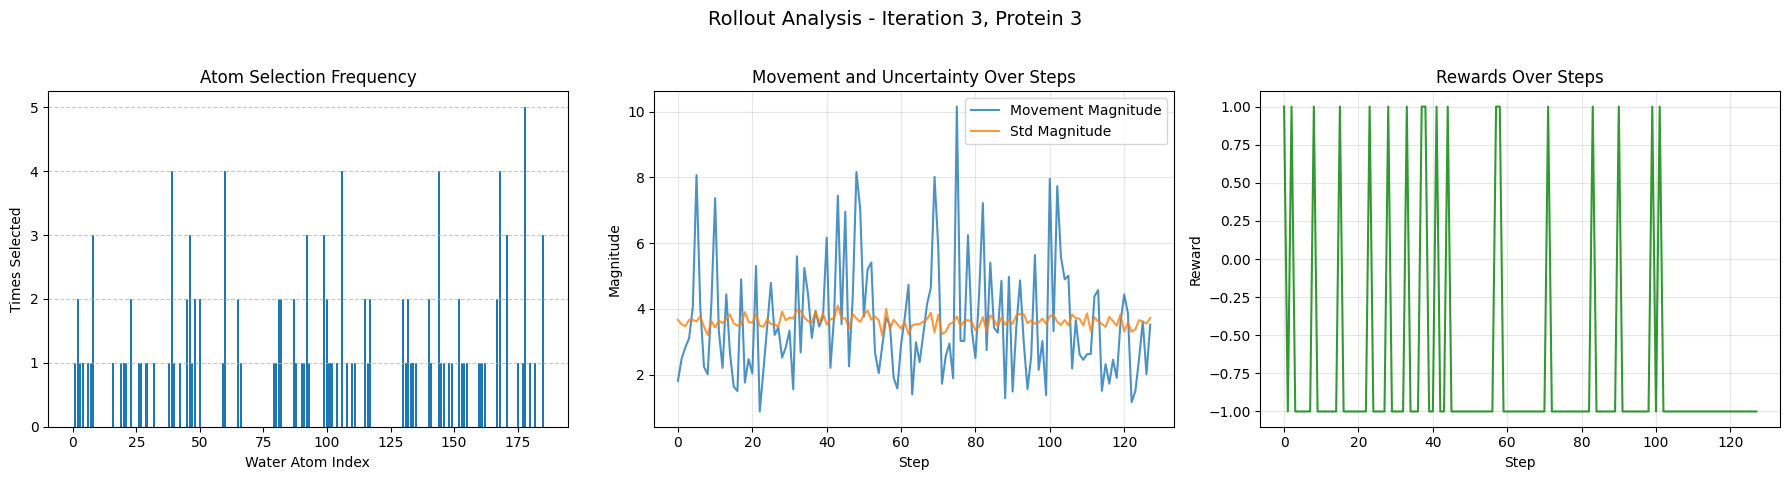

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0437 | Value Loss: 21.3311 | Entropy: 6.1007
Policy Loss: 0.0287 | Value Loss: 16.3670 | Entropy: 6.0872
Policy Loss: 0.0214 | Value Loss: 9.7640 | Entropy: 6.1166
Policy Loss: 0.0149 | Value Loss: 5.4895 | Entropy: 6.0730
	Protein 4/10


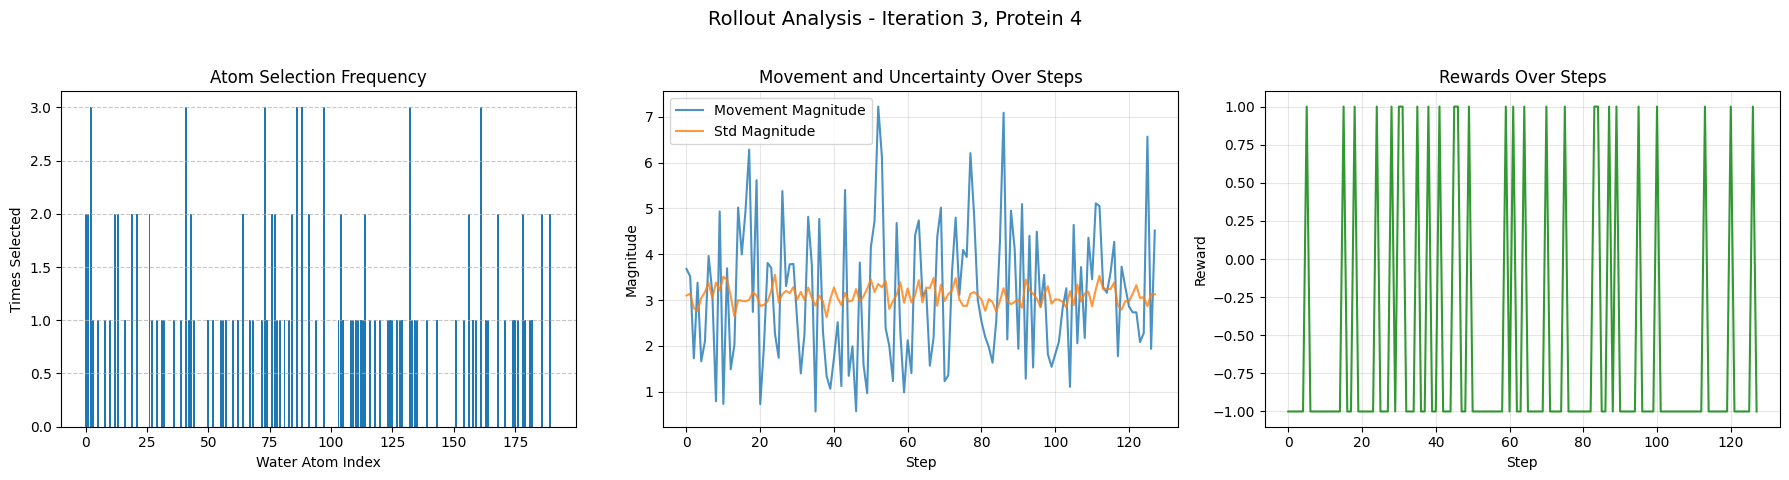

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0820 | Value Loss: 17.6602 | Entropy: 5.6876
Policy Loss: 0.0369 | Value Loss: 11.2416 | Entropy: 5.6818
Policy Loss: 0.0475 | Value Loss: 6.6418 | Entropy: 5.7926
Policy Loss: 0.0455 | Value Loss: 6.6148 | Entropy: 5.8600
	Protein 5/10


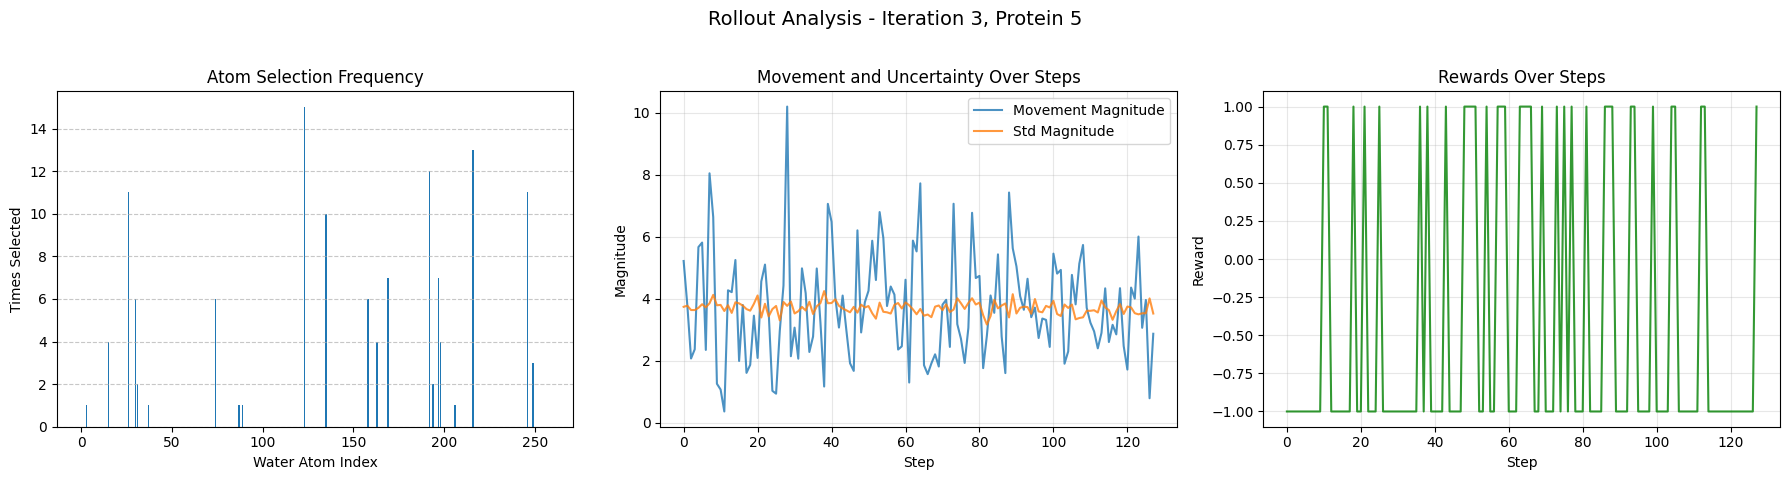

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0733 | Value Loss: 16.9863 | Entropy: 5.7990
Policy Loss: 0.0611 | Value Loss: 16.2542 | Entropy: 5.8352
Policy Loss: 0.0543 | Value Loss: 13.8530 | Entropy: 5.8862
Policy Loss: 0.0582 | Value Loss: 11.4596 | Entropy: 5.9033
	Protein 6/10


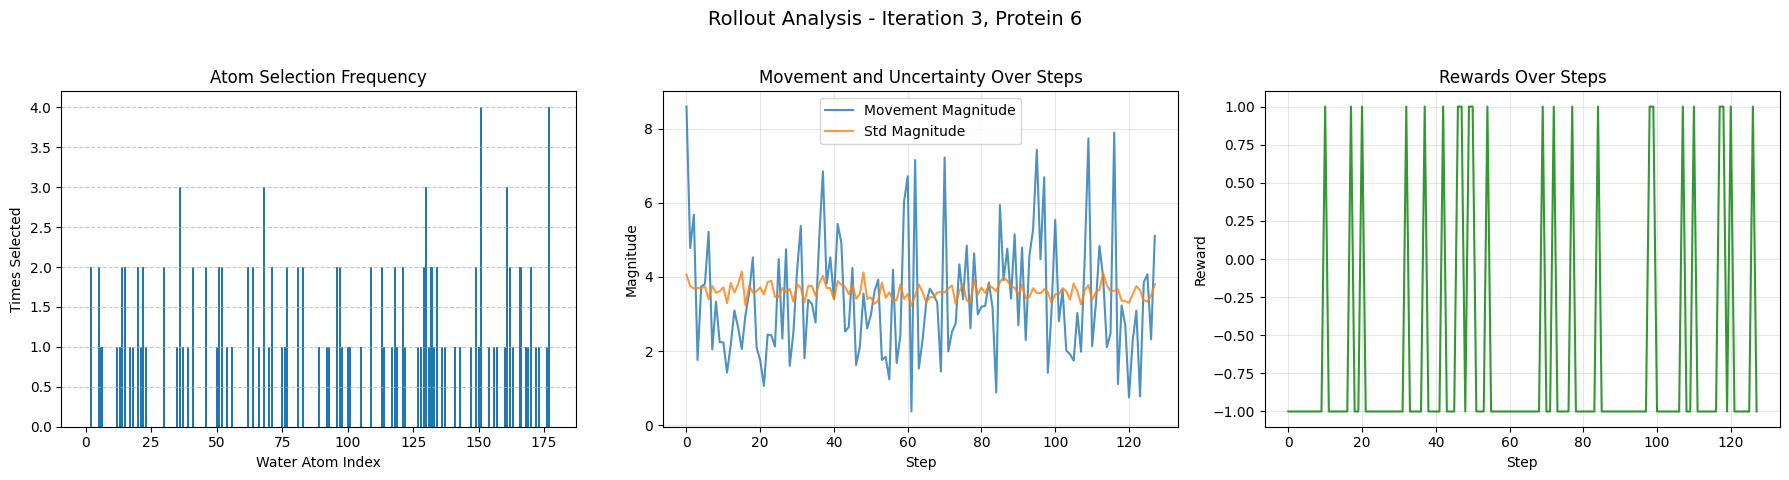

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0519 | Value Loss: 7.6236 | Entropy: 6.1361
Policy Loss: 0.0572 | Value Loss: 7.8202 | Entropy: 6.1546
Policy Loss: 0.0507 | Value Loss: 7.3440 | Entropy: 6.2002
Policy Loss: 0.0871 | Value Loss: 5.4959 | Entropy: 6.2050
	Protein 7/10


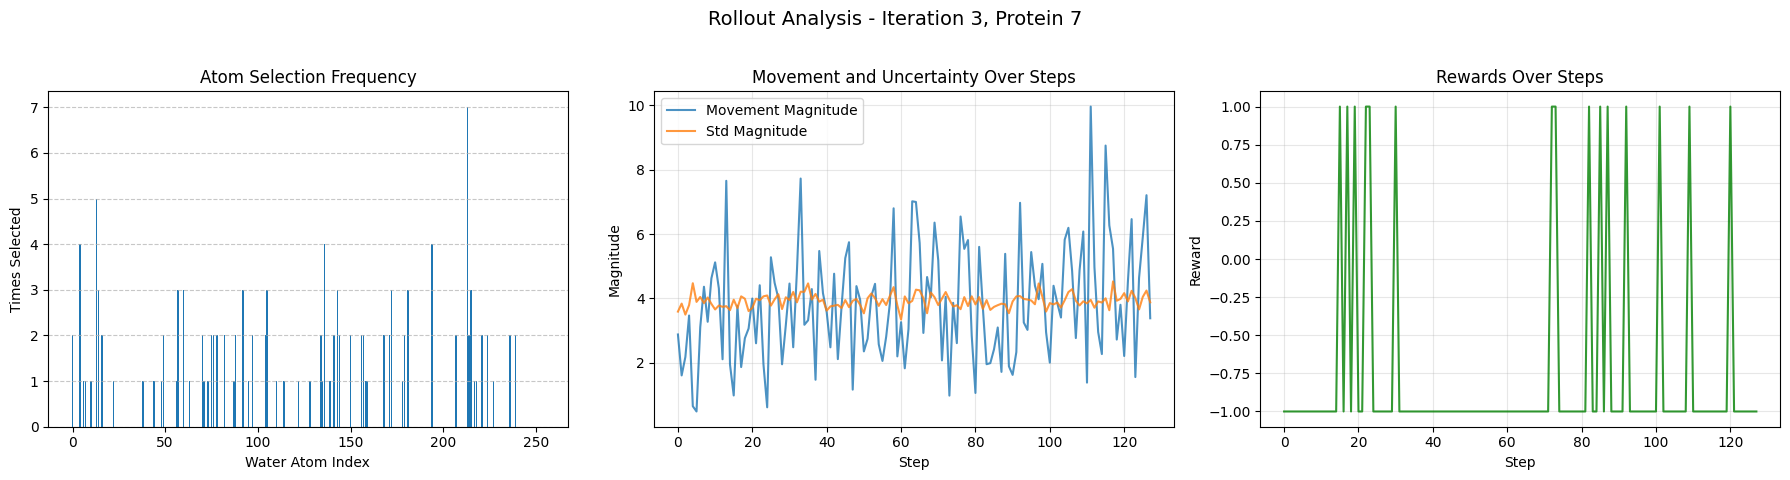

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0261 | Value Loss: 16.0297 | Entropy: 6.0770
Policy Loss: 0.0367 | Value Loss: 11.2359 | Entropy: 6.0765
Policy Loss: 0.0930 | Value Loss: 6.3755 | Entropy: 6.0787
Policy Loss: 0.0751 | Value Loss: 4.7396 | Entropy: 6.0901
	Protein 8/10


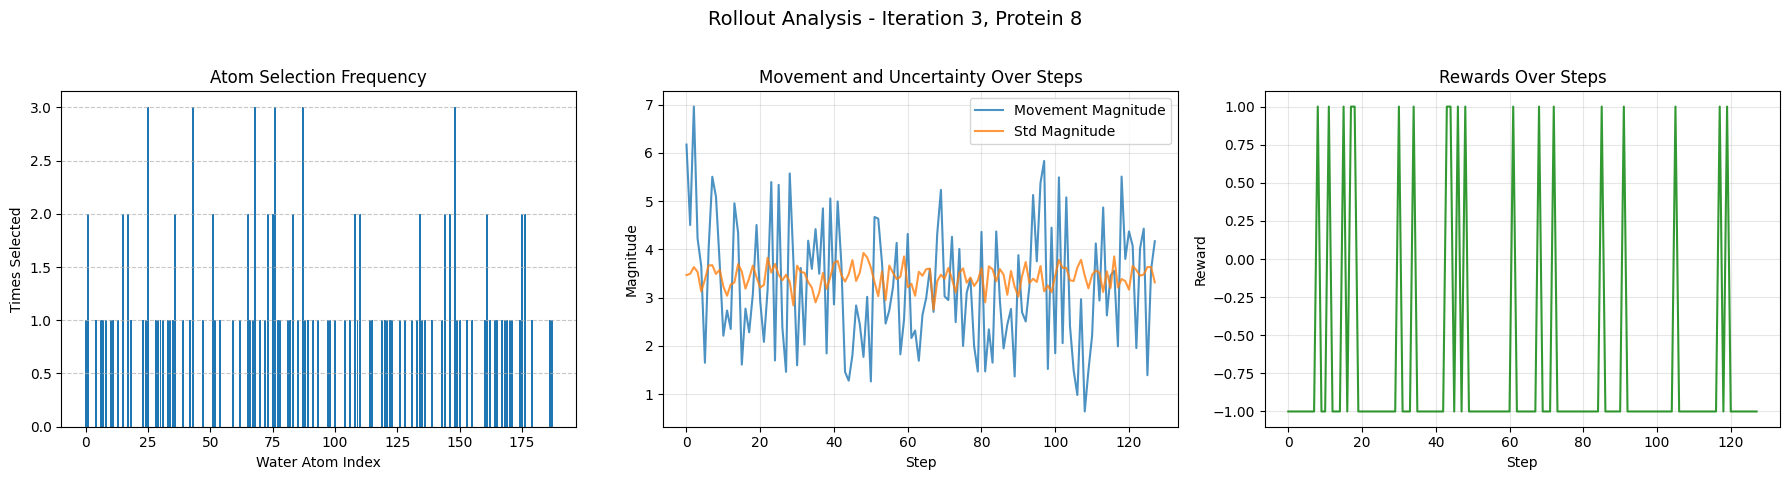

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0857 | Value Loss: 17.5880 | Entropy: 6.0738
Policy Loss: 0.0960 | Value Loss: 12.1752 | Entropy: 6.0341
Policy Loss: 0.0962 | Value Loss: 6.4221 | Entropy: 6.0652
Policy Loss: 0.1155 | Value Loss: 3.8806 | Entropy: 6.1187
	Protein 9/10


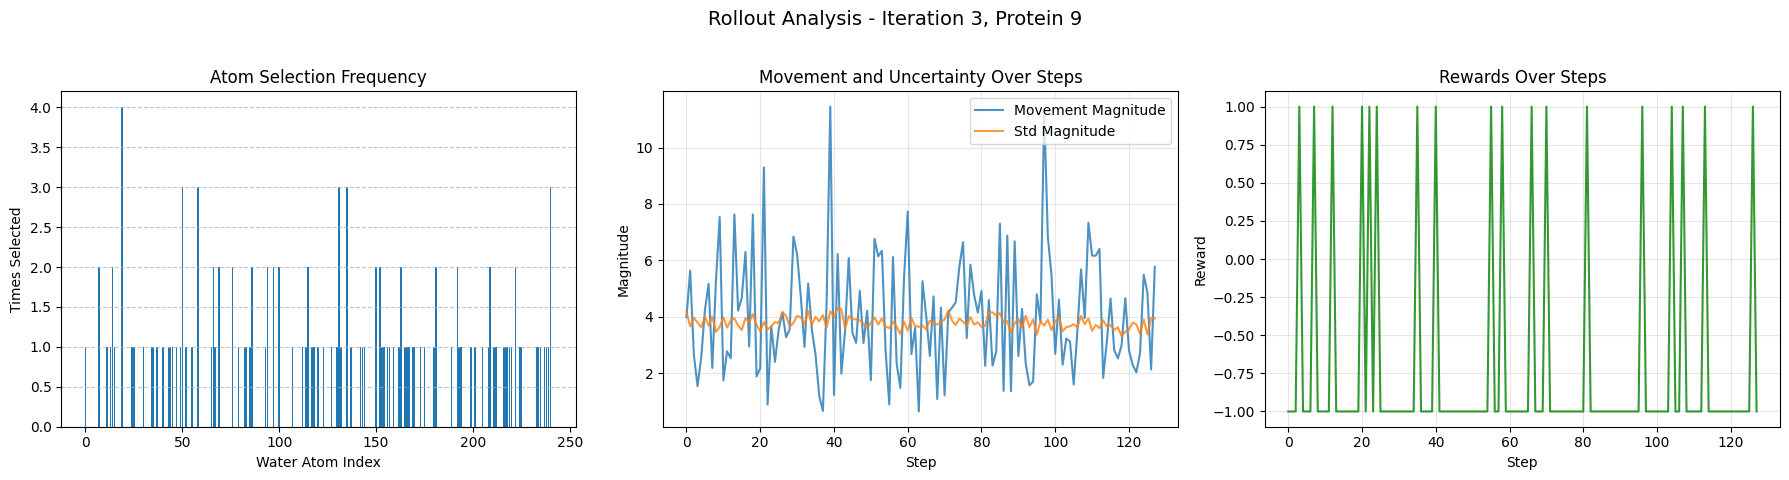

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0672 | Value Loss: 8.3051 | Entropy: 6.3143
Policy Loss: 0.0684 | Value Loss: 5.1452 | Entropy: 6.3305
Policy Loss: 0.0336 | Value Loss: 4.1495 | Entropy: 6.3549
Policy Loss: 0.0168 | Value Loss: 5.6314 | Entropy: 6.4499
	Protein 10/10


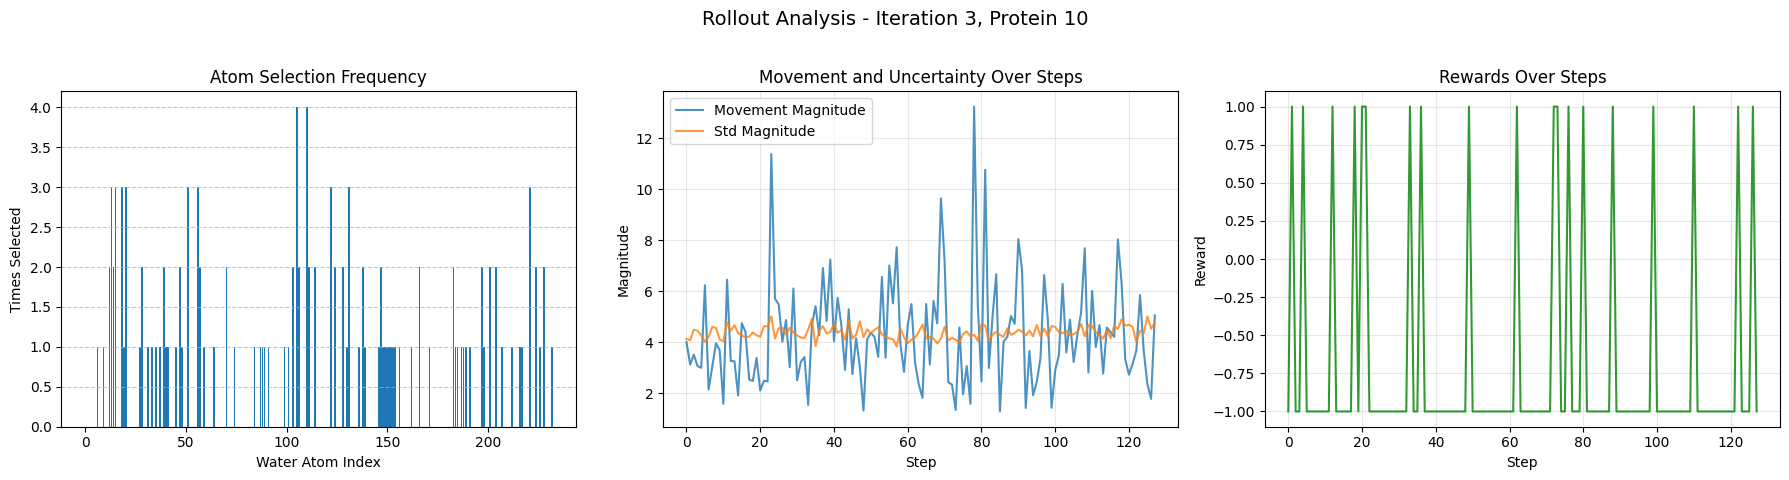

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.1107 | Value Loss: 6.2933 | Entropy: 5.9784
Policy Loss: 0.1171 | Value Loss: 4.4031 | Entropy: 5.9521
Policy Loss: 0.0399 | Value Loss: 3.2763 | Entropy: 5.7928
Policy Loss: 0.0599 | Value Loss: 4.1020 | Entropy: 5.6801

==================== EVALUATING ON TEST SET ====================

--- Starting Test Protein 1/10 --- 
  Starting  Distance=2.1488, Coverage=0.0179, Precision=0.0179
  Finished in 2500 steps. Final Distance=161.5843, Coverage=0.0000, Precision=0.0000


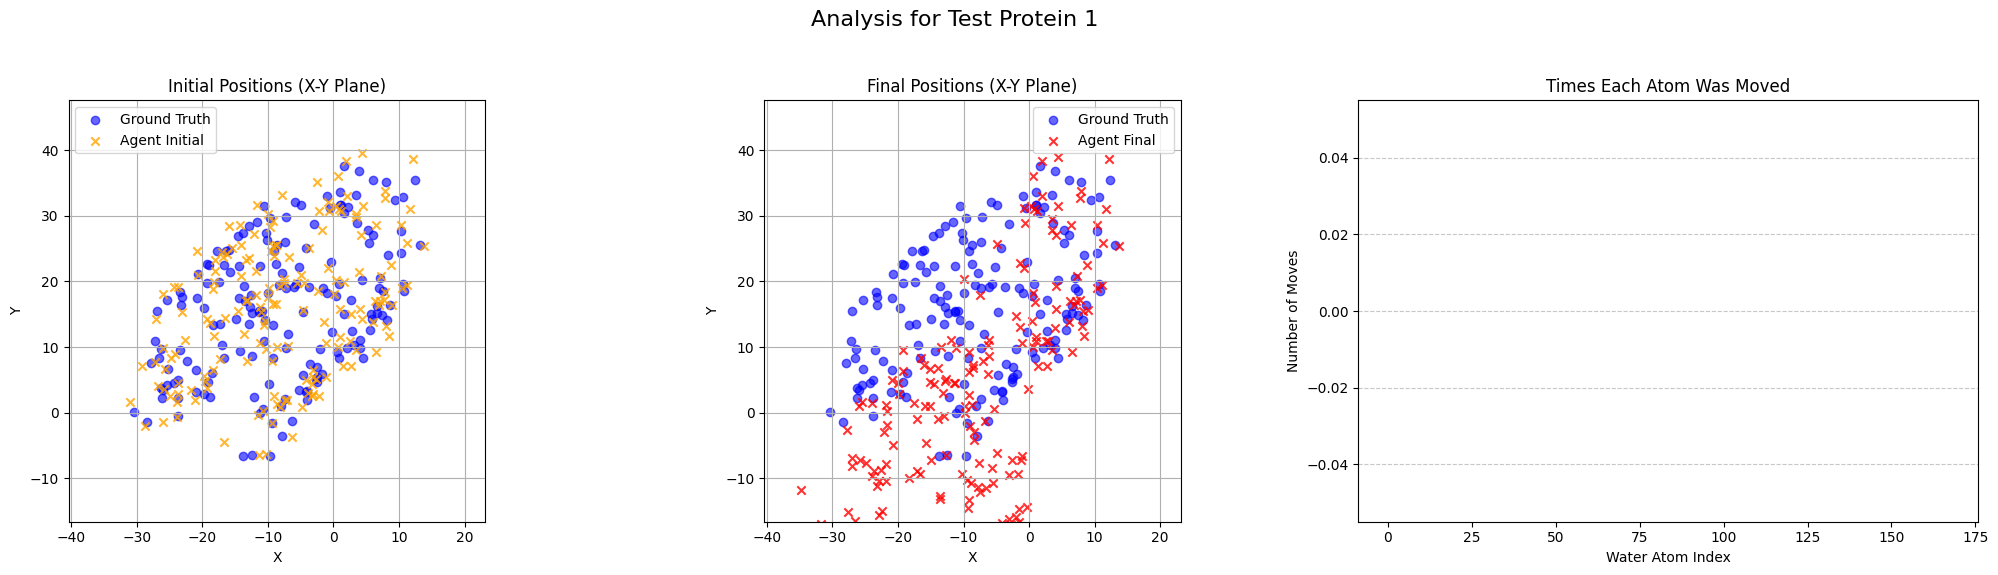


--- Starting Test Protein 2/10 --- 
  Starting  Distance=2.1987, Coverage=0.0170, Precision=0.0170
  Finished in 2500 steps. Final Distance=172.8391, Coverage=0.0057, Precision=0.0057

--- Starting Test Protein 3/10 --- 
  Starting  Distance=2.4464, Coverage=0.0376, Precision=0.0376
  Finished in 2500 steps. Final Distance=294.8484, Coverage=0.0161, Precision=0.0161

--- Starting Test Protein 4/10 --- 
  Starting  Distance=2.1675, Coverage=0.0052, Precision=0.0052
  Finished in 2500 steps. Final Distance=62.8041, Coverage=0.0052, Precision=0.0052

--- Starting Test Protein 5/10 --- 
  Starting  Distance=2.2904, Coverage=0.0116, Precision=0.0116
  Finished in 2500 steps. Final Distance=2149.7777, Coverage=0.0116, Precision=0.0116

--- Starting Test Protein 6/10 --- 
  Starting  Distance=2.2030, Coverage=0.0112, Precision=0.0112
  Finished in 2500 steps. Final Distance=143.6259, Coverage=0.0000, Precision=0.0000


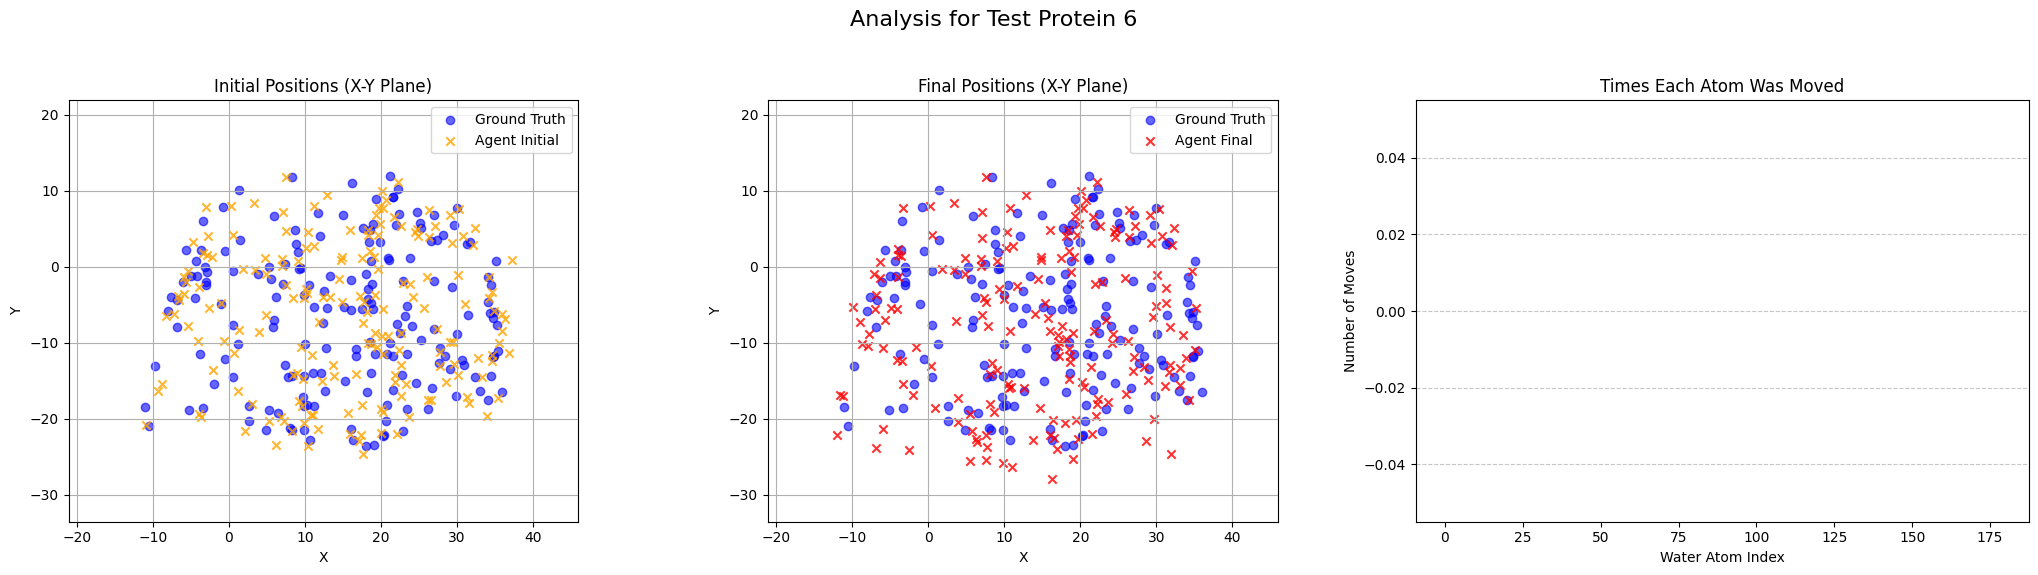


--- Starting Test Protein 7/10 --- 
  Starting  Distance=2.1384, Coverage=0.0157, Precision=0.0157
  Finished in 2500 steps. Final Distance=378.3971, Coverage=0.0157, Precision=0.0157

--- Starting Test Protein 8/10 --- 
  Starting  Distance=2.4628, Coverage=0.0053, Precision=0.0053
  Finished in 2500 steps. Final Distance=182.8190, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 9/10 --- 
  Starting  Distance=2.2994, Coverage=0.0207, Precision=0.0207
  Finished in 2500 steps. Final Distance=38.2541, Coverage=0.0000, Precision=0.0000

--- Starting Test Protein 10/10 --- 
  Starting  Distance=2.3187, Coverage=0.0258, Precision=0.0258
  Finished in 2500 steps. Final Distance=295.2867, Coverage=0.0215, Precision=0.0215

-------------------- TEST SUMMARY --------------------
Average Final Distance (MSE) on Test Set: 388.0236
Average Final Correlation on Test Set:  nan
Average Coverage on Test Set:         0.0076
Average Precision on Test Set:        0.0076


=== Iteration 4/5

/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


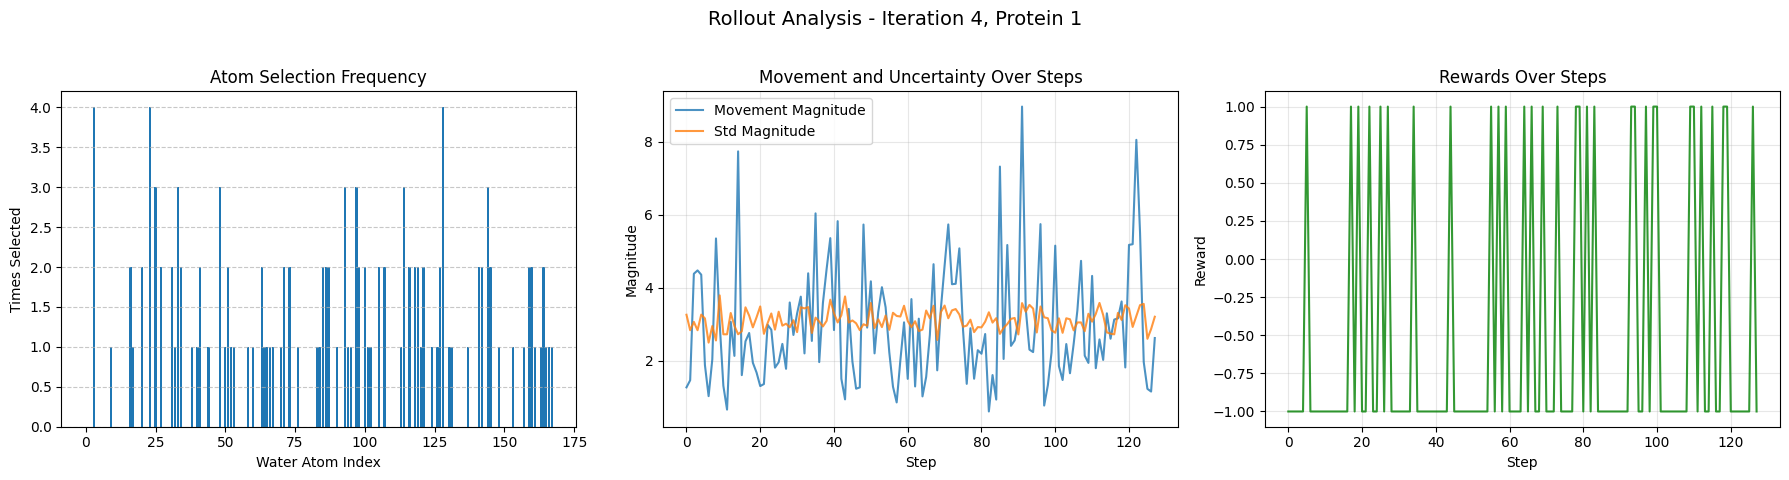

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0291 | Value Loss: 8.3921 | Entropy: 5.1159
Policy Loss: 0.0403 | Value Loss: 7.0078 | Entropy: 5.1747
Policy Loss: 0.0617 | Value Loss: 7.4216 | Entropy: 5.2386
Policy Loss: 0.0316 | Value Loss: 6.1047 | Entropy: 5.3513
	Protein 2/10


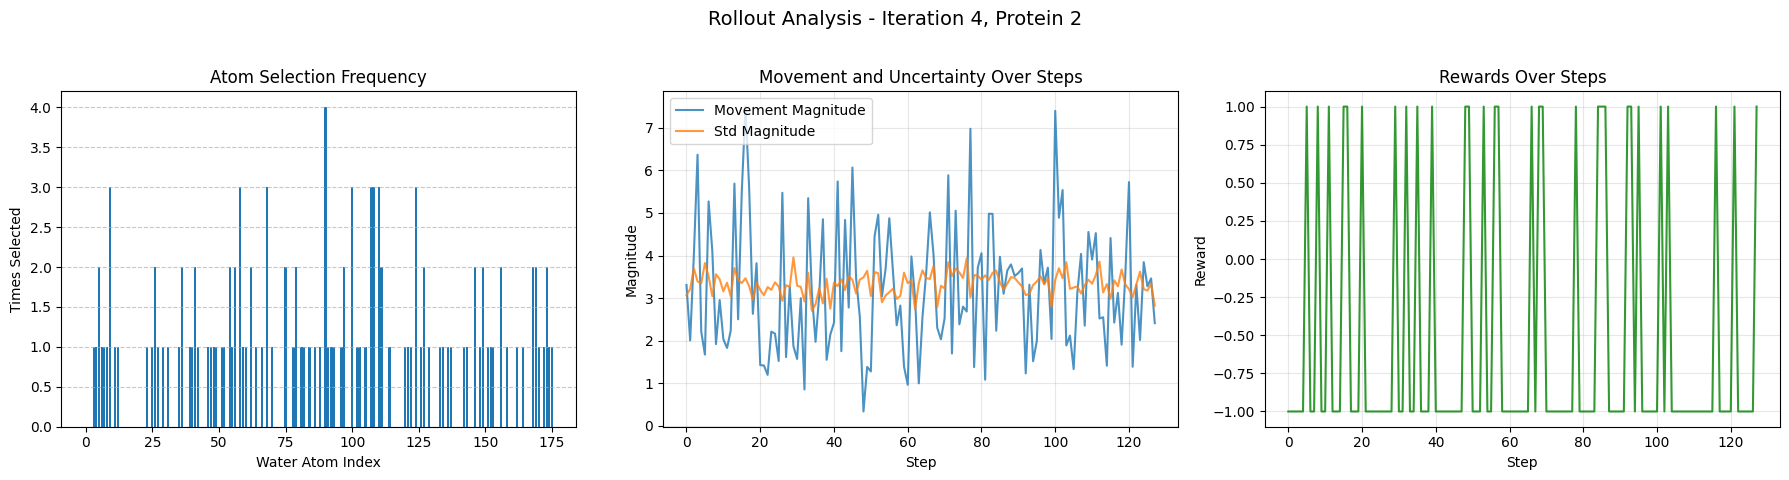

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0636 | Value Loss: 4.3931 | Entropy: 6.0650
Policy Loss: 0.0241 | Value Loss: 4.0056 | Entropy: 6.2197
Policy Loss: 0.0318 | Value Loss: 3.8930 | Entropy: 6.3159
Policy Loss: 0.0100 | Value Loss: 3.3728 | Entropy: 6.3922
	Protein 3/10


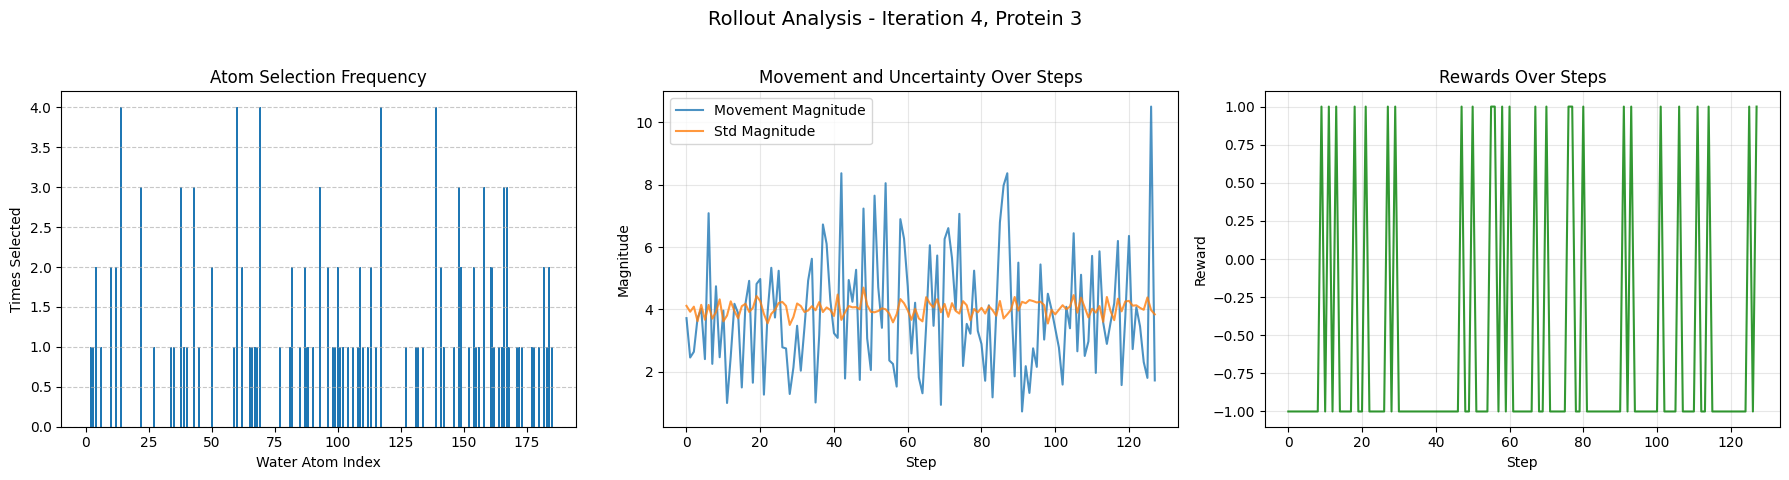

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0211 | Value Loss: 4.1163 | Entropy: 5.9442
Policy Loss: 0.0350 | Value Loss: 3.4829 | Entropy: 5.9616
Policy Loss: 0.0160 | Value Loss: 4.0109 | Entropy: 6.0013
Policy Loss: 0.0097 | Value Loss: 4.5861 | Entropy: 6.0568
	Protein 4/10


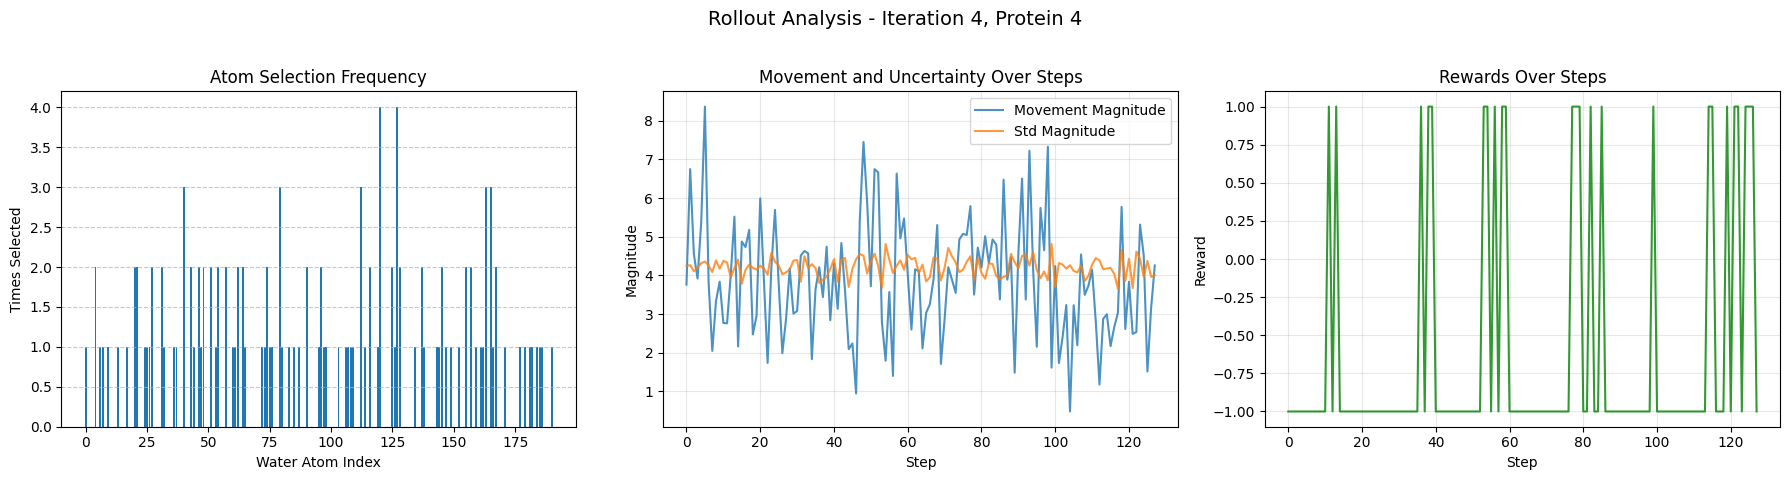

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0115 | Value Loss: 13.0784 | Entropy: 6.8380
Policy Loss: 0.0075 | Value Loss: 10.6474 | Entropy: 6.8597
Policy Loss: 0.0050 | Value Loss: 10.2043 | Entropy: 6.8064
Policy Loss: -0.0105 | Value Loss: 11.1887 | Entropy: 6.7281
	Protein 5/10


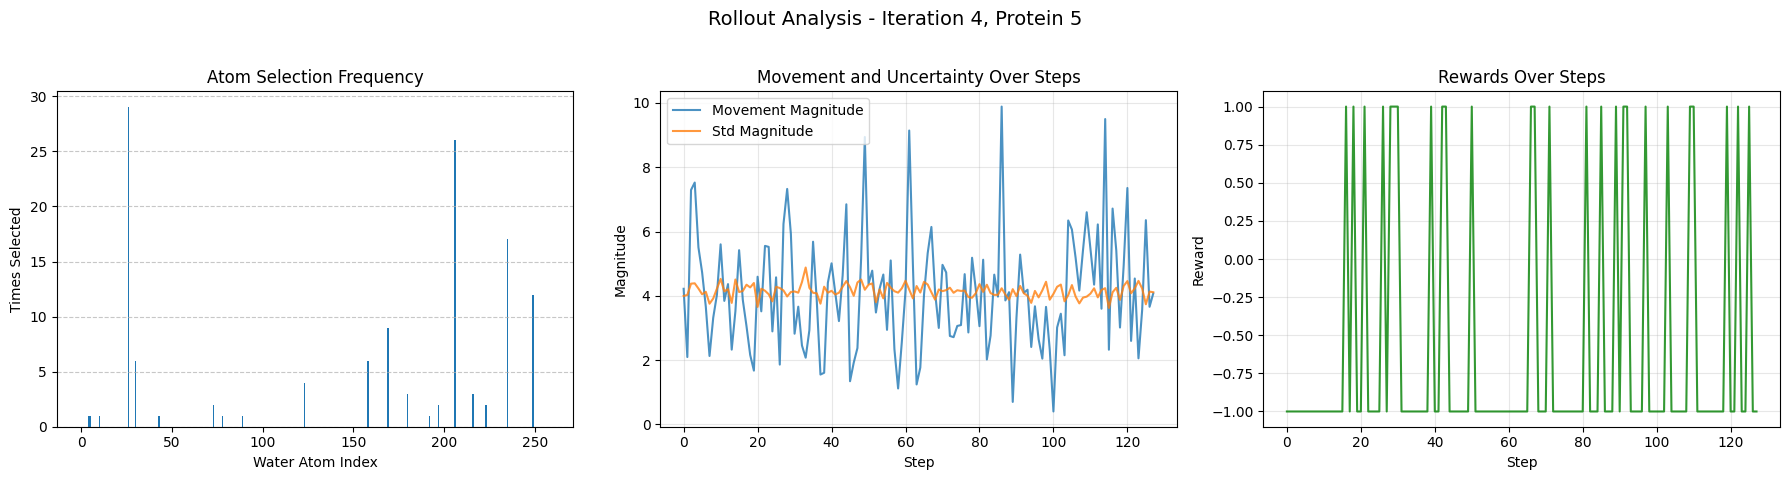

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.3380 | Value Loss: 5.0699 | Entropy: 5.8679
Policy Loss: 0.0728 | Value Loss: 4.7079 | Entropy: 5.6772
Policy Loss: 0.0559 | Value Loss: 4.2292 | Entropy: 5.7053
Policy Loss: 0.2694 | Value Loss: 3.6594 | Entropy: 5.7158
	Protein 6/10


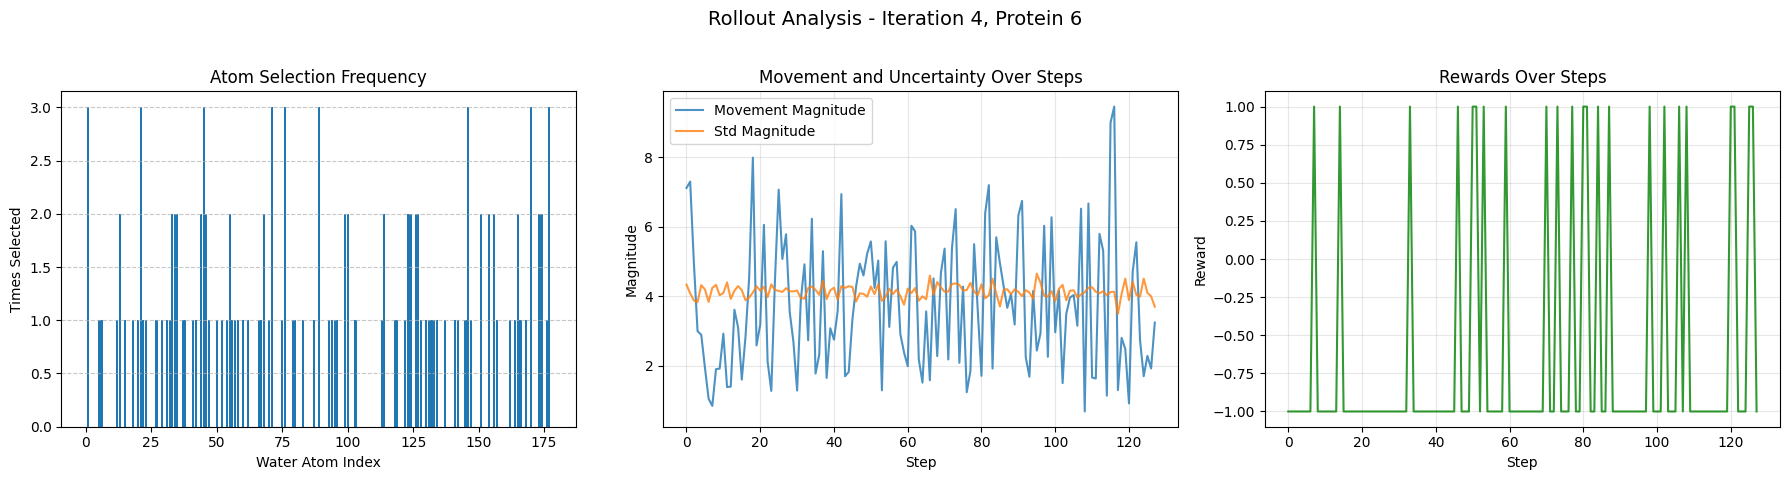

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0612 | Value Loss: 4.8613 | Entropy: 5.9844
Policy Loss: 0.0600 | Value Loss: 4.4287 | Entropy: 6.1164
Policy Loss: 0.1105 | Value Loss: 4.5703 | Entropy: 6.1851
Policy Loss: 0.0314 | Value Loss: 4.4306 | Entropy: 6.2224
	Protein 7/10


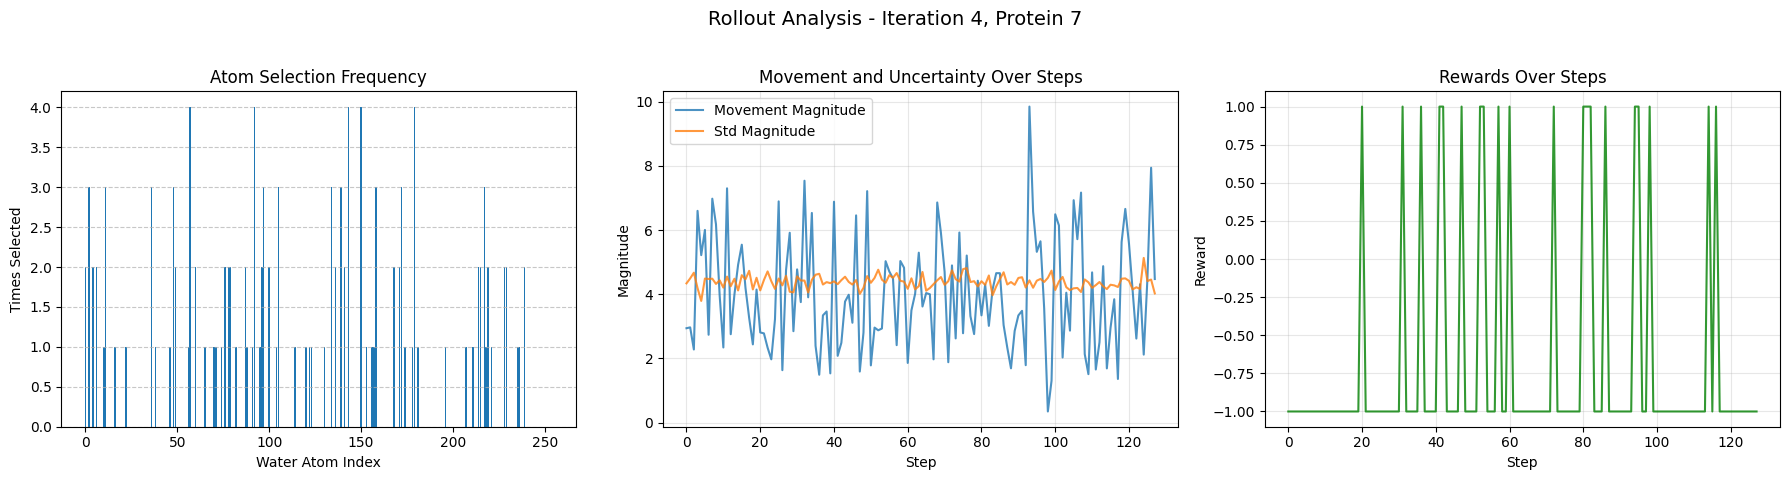

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.2565 | Value Loss: 4.9969 | Entropy: 5.8897
Policy Loss: 0.0894 | Value Loss: 5.7673 | Entropy: 6.0049
Policy Loss: 0.0628 | Value Loss: 4.9289 | Entropy: 6.0672
Policy Loss: 0.0730 | Value Loss: 4.8627 | Entropy: 6.0010
	Protein 8/10


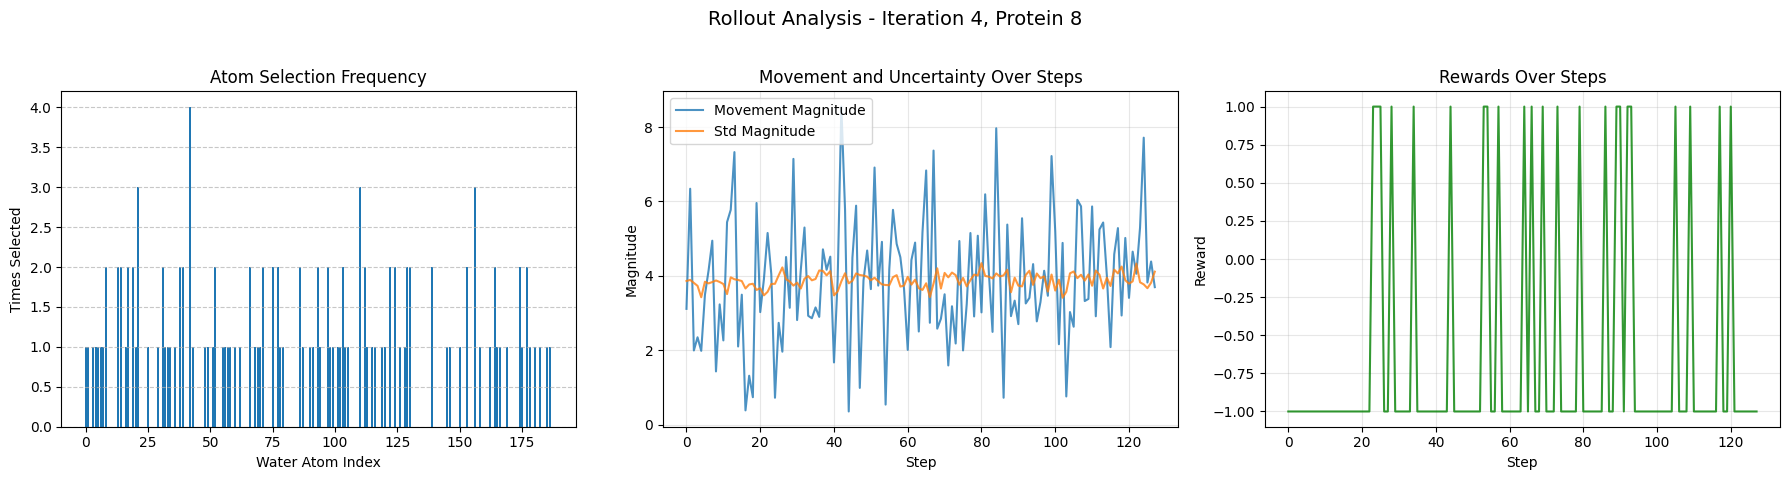

Training epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Policy Loss: 0.0327 | Value Loss: 5.7082 | Entropy: 6.5674
Policy Loss: 0.0090 | Value Loss: 4.4642 | Entropy: 6.5236
Policy Loss: 0.0061 | Value Loss: 4.2241 | Entropy: 6.4929
Policy Loss: 0.0044 | Value Loss: 4.5652 | Entropy: 6.5804
	Protein 9/10


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")


for training in range(n_repeats):
    print(f"\n=== Iteration {training + 1}/{n_repeats} ===")
    noise_value = noise_values[training]
    print(f"Noise Value: {noise_value}")
    my_env = PDB_Env(train_data['water_indices'], train_data['protein_indices'], n_repeats=n_repeats, noise=noise_value, termination_reward=termination_reward, termination_mse=termination_mse)
    test_env = PDB_Env(test_data['water_indices'], test_data['protein_indices'], n_repeats=n_repeats, noise=noise_value, termination_reward=termination_reward, termination_mse=termination_mse)

    for protein in range(len(train_pdb_files)):
        print(f"\tProtein {protein + 1}/{len(train_pdb_files)}")
        rollout_buffer.reset()
        obs_dict, info = my_env.reset()
        episode_start = True

        if training == 0:
            protein_filename = os.path.basename(train_pdb_files[protein])
            output_filename = f"{protein_filename.replace('.pdb', '')}_initial_noise.pdb"

            print(f"\tSaving initial noisy structure to {output_filename}")
            save_protein_and_density(
                water_struct=obs_dict['agent_info'],
                protein_struct=obs_dict['protein_info'],
                target_struct_for_density=obs_dict['target_info'],
                filepath=output_filename,
                title=f"Initial noise added for {protein_filename}"
            )

        # === TRACKING LISTS FOR VISUALIZATION ===
        atom_selections = []
        movement_norms = []
        movement_std_norms = []
        rewards_list = []

        for step in tqdm(range(buffer_size), desc="Collecting rollout", unit="step"):
            protein_struct = obs_dict["protein_info"]
            water_struct = obs_dict["agent_info"]
            target_xmap = obs_dict["target_xmap"]

            atom_to_move_idx = select_worst_water_by_density_score(water_struct, target_xmap)

            full_protein_elements = np.concatenate((protein_struct.e, water_struct.e))
            full_protein_coords = torch.vstack((torch.tensor(protein_struct.coor), torch.tensor(water_struct.coor)))
            agent_edge_index, agent_edge_weight = build_knn_graph(full_protein_coords.numpy(), k=k)
            n_protein = protein_struct.coor.shape[0]

            movement_mean, movement_std, state_value = policy_net(
                full_protein_coords.float().to(device),
                full_protein_elements,
                agent_edge_index.to(device),
                atom_to_move_index=atom_to_move_idx
            )

            movement_dist = Normal(movement_mean, movement_std)
            movement = movement_dist.sample()

            total_log_prob = movement_dist.log_prob(movement).sum()

            next_obs_dict, reward, terminated, truncated, new_info = my_env.step(atom_to_move_idx, movement)
            done = terminated or truncated

            # Update info dictionary for the next iteration if needed
            info = new_info


            # === TRACK METRICS FOR VISUALIZATION ===
            atom_selections.append(atom_to_move_idx)
            movement_norms.append(torch.linalg.norm(movement).item())
            movement_std_norms.append(torch.linalg.norm(movement_std).item())
            rewards_list.append(reward)


            rollout_buffer.add(
                obs_dict, atom_to_move_idx, movement, reward, episode_start,
                state_value, total_log_prob, agent_edge_index, agent_edge_weight
            )
            obs_dict = next_obs_dict
            episode_start = done

        # === VISUALIZATION AFTER ROLLOUT COLLECTION ===
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'Rollout Analysis - Iteration {training + 1}, Protein {protein + 1}', fontsize=14)

        # Plot 1: Bar chart of atom selections
        n_water = obs_dict["agent_info"].coor.shape[0]
        atom_counts = np.bincount(atom_selections, minlength=n_water)
        axes[0].bar(range(len(atom_counts)), atom_counts)
        axes[0].set_title('Atom Selection Frequency')
        axes[0].set_xlabel('Water Atom Index')
        axes[0].set_ylabel('Times Selected')
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)

        # Plot 2: Line plot of movement and std magnitudes
        steps_range = range(len(movement_norms))
        axes[1].plot(steps_range, movement_norms, label='Movement Magnitude', alpha=0.8)
        axes[1].plot(steps_range, movement_std_norms, label='Std Magnitude', alpha=0.8)
        axes[1].set_title('Movement and Uncertainty Over Steps')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Magnitude')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Plot 3: Line plot of rewards
        axes[2].plot(steps_range, rewards_list, color='green', alpha=0.8)
        axes[2].set_title('Rewards Over Steps')
        axes[2].set_xlabel('Step')
        axes[2].set_ylabel('Reward')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

        # --- Continue with PPO update ---
        protein_struct = obs_dict["protein_info"]
        water_struct = obs_dict["agent_info"]
        target_xmap = obs_dict["target_xmap"]

        last_atom_to_move_idx = select_worst_water_by_density_score(water_struct, target_xmap)

        full_protein_coords = torch.vstack((torch.tensor(protein_struct.coor), torch.tensor(water_struct.coor)))
        full_protein_elements = np.concatenate((protein_struct.e, water_struct.e))
        agent_edge_index, _ = build_knn_graph(full_protein_coords.numpy(), k=k)
        n_protein = protein_struct.coor.shape[0]

        with torch.no_grad():
            _, _, last_value = policy_net(
                full_protein_coords.float().to(device),
                full_protein_elements,
                agent_edge_index.to(device),
                atom_to_move_index=last_atom_to_move_idx
            )
        rollout_buffer.compute_returns_and_advantage(last_value, np.array([done]))

        for epoch in tqdm(range(epochs), desc="Training epochs", unit="epoch"):
            epoch_policy_losses, epoch_value_losses, epoch_entropies = [], [], []
            for batch in rollout_buffer.get(batch_size=batch_size):
                (agent_pos_batch, protein_pos_batch, atom_moved_indices_batch, sampled_movements_batch,
                 values_batch, old_log_probs_batch, advantages_batch, returns_batch,
                 edge_indices_batch, edge_weights_batch) = batch

                advantages_batch = (advantages_batch - advantages_batch.mean()) / (advantages_batch.std() + 1e-8)
                policy_losses, value_losses, entropies = [], [], []

                for ii in range(len(advantages_batch)):
                    protein_pos, agent_pos = protein_pos_batch[ii].coor, agent_pos_batch[ii].coor
                    protein_atoms, agent_atoms = protein_pos_batch[ii].e, agent_pos_batch[ii].e
                    full_protein = np.vstack([protein_pos, agent_pos])
                    full_protein_elements = np.concatenate([protein_atoms, agent_atoms])
                    edge_index = edge_indices_batch[ii].long().to(device)
                    atom_to_move_idx = atom_moved_indices_batch[ii]

                    new_movement_mean, new_movement_std, new_value = policy_net(
                        torch.tensor(full_protein).float().to(device),
                        full_protein_elements,
                        edge_index,
                        atom_to_move_index=atom_to_move_idx
                    )

                    movement_dist = Normal(new_movement_mean, new_movement_std)
                    old_movement = sampled_movements_batch[ii]
                    new_log_prob = movement_dist.log_prob(old_movement).sum()
                    ratio = torch.exp(new_log_prob - old_log_probs_batch[ii])

                    surr1 = ratio * advantages_batch[ii]
                    surr2 = torch.clamp(ratio, 0.8, 1.2) * advantages_batch[ii]
                    policy_loss = -torch.min(surr1, surr2)

                    entropy = movement_dist.entropy().sum()
                    entropies.append(entropy)
                    policy_losses.append(policy_loss)
                    value_losses.append(F.mse_loss(new_value.squeeze(), returns_batch[ii]))

                total_policy_loss = torch.stack(policy_losses).mean()
                total_value_loss = torch.stack(value_losses).mean()
                total_entropy = torch.stack(entropies).mean()
                total_loss = total_policy_loss + value_coef * total_value_loss - ent_coef * total_entropy

                epoch_policy_losses.append(total_policy_loss.item())
                epoch_value_losses.append(total_value_loss.item())
                epoch_entropies.append(total_entropy.item())

                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
                optimizer.step()

            print(f"Policy Loss: {np.mean(epoch_policy_losses):.4f} | Value Loss: {np.mean(epoch_value_losses):.4f} | Entropy: {np.mean(epoch_entropies):.4f}")

    # --- Test Loop ---
    print("\n" + "="*20 + " EVALUATING ON TEST SET " + "="*20)
    all_final_distances, all_final_correlations = [], []
    all_coverages, all_precisions = [], []
    policy_net.eval()

    for test in range(len(test_data['water_indices'])):
        obs_dict, info = test_env.reset()

        initial_agent_coords = obs_dict['agent_info'].coor.copy()
        num_waters = initial_agent_coords.shape[0]
        move_counts = np.zeros(num_waters, dtype=int)
        episode_steps = 0
        max_episode_steps = 2500

        coverage, precision = cov_prec_at_threshold(initial_agent_coords, obs_dict['target_info'].coor)
        print(f"\n--- Starting Test Protein {test + 1}/{len(test_data['water_indices'])} --- ")
        print(f"  Starting  Distance={info['distance']:.4f}, Coverage={coverage:.4f}, Precision={precision:.4f}")

        while episode_steps < max_episode_steps:
            with torch.no_grad():
                protein_struct = obs_dict["protein_info"]
                water_struct = obs_dict["agent_info"]
                target_xmap = obs_dict["target_xmap"]

                atom_to_move_idx= select_worst_water_by_density_score(water_struct, target_xmap)

                full_protein_coords = torch.vstack((torch.tensor(protein_struct.coor), torch.tensor(water_struct.coor)))
                full_protein_elements = np.concatenate((protein_struct.e, water_struct.e))
                agent_edge_index, _ = build_knn_graph(full_protein_coords.numpy(), k=k)

                movement_mean, _, _ = policy_net(
                    full_protein_coords.float().to(device),
                    full_protein_elements,
                    agent_edge_index.to(device),
                    atom_to_move_index=atom_to_move_idx
                )
                movement = movement_mean

            obs_dict, reward, terminated, truncated, info = test_env.step_test(atom_to_move_idx, movement)
            episode_steps += 1

        if training == n_repeats - 1:
            protein_filename = os.path.basename(test_pdb_files[test])
            output_filename = f"{protein_filename.replace('.pdb', '')}_final_run.pdb"

            print(f"  Saving final structure to {output_filename}")
            save_waters_to_pdb(
                water_struct=test_env._agent_info,
                protein_struct=test_env._curr_protein_atoms,
                target_struct_for_density=obs_dict['target_info'],
                filepath=output_filename,
                title=f"Final positions after last training run for {protein_filename}"
            )

        final_info = test_env._get_info()
        agent_coords = test_env._agent_info.coor
        target_coords = test_env._target_info.coor

        final_distance = final_info['distance']
        coverage, precision = cov_prec_at_threshold(agent_coords, target_coords)

        all_final_distances.append(final_distance)
        all_coverages.append(coverage)
        all_precisions.append(precision)

        print(f"  Finished in {episode_steps} steps. Final Distance={final_distance:.4f}, Coverage={coverage:.4f}, Precision={precision:.4f}")

        if (test) % 5 == 0:
            buffer = 10.0
            x_lim = (target_coords[:, 0].min() - buffer, target_coords[:, 0].max() + buffer)
            y_lim = (target_coords[:, 1].min() - buffer, target_coords[:, 1].max() + buffer)

            fig, axes = plt.subplots(1, 3, figsize=(21, 6))
            fig.suptitle(f'Analysis for Test Protein {test + 1}', fontsize=16)

            axes[0].scatter(target_coords[:, 0], target_coords[:, 1], c='blue', alpha=0.6, label='Ground Truth')
            axes[0].scatter(initial_agent_coords[:, 0], initial_agent_coords[:, 1], c='orange', alpha=0.8, marker='x', label='Agent Initial')
            axes[0].set_title('Initial Positions (X-Y Plane)'); axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
            axes[0].legend(); axes[0].grid(True); axes[0].set_aspect('equal', adjustable='box')
            axes[0].set_xlim(x_lim); axes[0].set_ylim(y_lim)

            axes[1].scatter(target_coords[:, 0], target_coords[:, 1], c='blue', alpha=0.6, label='Ground Truth')
            axes[1].scatter(agent_coords[:, 0], agent_coords[:, 1], c='red', alpha=0.8, marker='x', label='Agent Final')
            axes[1].set_title('Final Positions (X-Y Plane)'); axes[1].set_xlabel('X'); axes[1].set_ylabel('Y')
            axes[1].legend(); axes[1].grid(True); axes[1].set_aspect('equal', adjustable='box')
            axes[1].set_xlim(x_lim); axes[1].set_ylim(y_lim)

            atom_indices = np.arange(num_waters)
            axes[2].bar(atom_indices, move_counts)
            axes[2].set_title('Times Each Atom Was Moved'); axes[2].set_xlabel('Water Atom Index'); axes[2].set_ylabel('Number of Moves')
            axes[2].grid(axis='y', linestyle='--', alpha=0.7)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    avg_distance = np.mean(all_final_distances)
    avg_correlation = np.mean(all_final_correlations)
    avg_coverage = np.mean(all_coverages)
    avg_precision = np.mean(all_precisions)

    print("\n" + "-"*20 + " TEST SUMMARY " + "-"*20)
    print(f"Average Final Distance (MSE) on Test Set: {avg_distance:.4f}")
    print(f"Average Final Correlation on Test Set:  {avg_correlation:.4f}")
    print(f"Average Coverage on Test Set:         {avg_coverage:.4f}")
    print(f"Average Precision on Test Set:        {avg_precision:.4f}")
    print("="*64 + "\n")

    policy_net.train()